In [1]:
import pandas as pd
import numpy as np
import scipy as sp

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import mpl_toolkits as mplot3d

pd.set_option("display.max_columns", None)
pd.set_option('future.no_silent_downcasting', True)

from tqdm import tqdm
tqdm.pandas()

In [2]:
import_folder_path = rf"../../data_cleaned/india/dynata"

# DATA WRANGLING

In [3]:
df00 = pd.read_csv(rf"{import_folder_path}/Indian Risk Literacy DYNATA_280525.csv")[26:]
df00[["Q9b_11", "Q9b_5", "Q9b_6", "Q9b_12"]] = df00[["Q9b_11", "Q9b_5", "Q9b_6", "Q9b_12"]].astype(float)
df00["Q9b_11"] = df00["Q9b_5"] + df00["Q9b_11"]
df00["Q9b_12"] = df00["Q9b_6"] + df00["Q9b_12"]
df00.drop(["Q9b_5", "Q9b_6"], axis = 1, inplace = True)
# 
df00.rename({"ResponseId":"responseid"}, axis = 1, inplace = True)

# drop na in responses
df01 = df00.dropna(subset = df00.columns[19:77])
print("Post dropping NA:", len(df01["responseid"]))

# removing students
df01 = df01.loc[ ~(df01["Q4a"] == "Student")].copy()
print("Post removing students:", len(df01["responseid"]))

# removing straight liners
matrix = ["Q8_1", "Q8_2", "Q8_3", "Q8_4", "Q8_5", "Q8_6", "Q8_7", "Q8_8"]
conversion_dict = {"1 (strongly disagree)":1 , "2":2, "3":3, "4":4, "5":5, "6 (strongly agree)":6}
for ques in matrix:
    df01[ques] = df01[ques].astype(str).replace(conversion_dict)

df01[ques] = pd.to_numeric(df01[ques], errors='coerce')

df01["Q8_std"] = df01[matrix].std(axis = 1)
df01 = df01.loc[ df01["Q8_std"] != 0].copy()
print("Post removing straightliners:", len(df01["responseid"]))

# attention check
df01 = df01.loc[ df01["Attention Check"] == "Vase"].copy()
print("Post attention chaeck failures:", len(df01["responseid"]))

# <0.5 median time of completion filtered
df01["Duration (in seconds)"] = df01["Duration (in seconds)"].astype("Int64")
median = df01["Duration (in seconds)"].astype("Int64").median()
df01 = df01.loc[ df01["Duration (in seconds)"] >= median*0.5].copy()
print("Post removing <0.5 median time responses:", len(df01["responseid"]))

# ONLY SALARIED 
df01 = df01.loc[ df01["Q4a"] == "Salaried"].copy()
print("Post removing non-salaried responses:", len(df01["responseid"]))

df0 = df01.iloc[:, 19:77].copy().reset_index(drop = True)
df0.insert(0, "responseid", range(0, len(df0)))

Post dropping NA: 963
Post removing students: 961
Post removing straightliners: 846
Post attention chaeck failures: 846
Post removing <0.5 median time responses: 699
Post removing non-salaried responses: 490


In [4]:
df0["age"] = df0["Q2"].astype(float).copy()

# Age groups/rec = [2,3,4]
# Age group 2 = 18 to 35 y/o
# Age group 3 = 36 to 55 y/o
# Age group 4 = 56 to 75 y/o (75 y/o, i.e, within the scope of the data we have, it can mean 60 and above also)

df0["age_rec"] = np.where( (df0["age"] >= 18) & (df0["age"] <= 35), 2,
                          np.where( (df0["age"] >= 36) & (df0["age"] <= 55), 3,
                                   np.where( (df0["age"] >= 56), 4, 0
                                           )
                                  )
                         )

# Secondary upto 10 – ISCED 3
# Senior Secondary upto 12 - ISCED 3 
# Diploma and voca – ISCED 2
# UG – ISCED 2
# PG – ISCED 1
# PhD and higher – ISCED 1

df0["isced"] = np.where(df0["Q3"] == "Post-Graduate Program", 1,
                        np.where(df0["Q3"] == "Undergraduate Program", 2,
                                 np.where(df0["Q3"] == "Ph.D. and higher", 1,
                                          np.where(df0["Q3"] == "Diploma and Vocational Training", 2,
                                                   np.where(df0["Q3"] == "Secondary School (11th to 12th Std.)", 3,
                                                            np.where( df0["Q3"] == "Primary School (up to 10th Std.)", 3,
                                                                     np.where( df0["Q3"] == "M.Phil.", 1, 0
                                                                             )
                                                                    )
                                                           )
                                                  )
                                         )
                                )
                       )

df0["income"] = np.where(df0["Q15a"] == "< INR 500,000", 1,
                         np.where(df0["Q15a"] == "INR 500,001 – INR 15,00,000", 2,
                                  np.where(df0["Q15a"] == "INR 1500,001 – INR 30,00,000", 3,
                                           np.where(df0["Q15a"] == "INR 30,00,001 – INR 50,00,000", 4,
                                                    np.where(df0["Q15a"] == "INR 50,00,001 – INR 75,00,000", 5,
                                                             np.where( df0["Q15a"] == "> INR 75,00,000", 6,0
                                                                     )
                                                            )
                                                   )
                                           )
                                  )
                         )

df0["wealth"] = df0["Q14b"].astype(float).copy()

In [5]:
def remove_indexname(series): # removes index name
    series.index.name = None
    series.name = None
    return series.to_string()

print("Total Observations:", df0["Q1"].count())

print(f'\nGender:\n{remove_indexname(df0["Q1"].value_counts())}')
print(f'\nOccupation:\n{remove_indexname(df0["Q4a"].value_counts())}')
print(f'\nEducation:\n{remove_indexname(df0["Q3"].value_counts())}')
print(f'\nISCED:\n{remove_indexname(df0["isced"].value_counts())}')
print(f'\nIncome:\n{remove_indexname(df0["Q15a"].value_counts().iloc[[1, 0, 2, 3, 4, 5]])}')

Total Observations: 490

Gender:
Male      256
Female    234

Occupation:
Salaried    490

Education:
Post-Graduate Program                   183
Undergraduate Program                   151
Secondary School (11th to 12th Std.)     98
Diploma and Vocational Training          25
Ph.D. and higher                         13
Primary School (up to 10th Std.)         12
M.Phil.                                   8

ISCED:
1    204
2    176
3    110

Income:
< INR 500,000                    103
INR 500,001 – INR 15,00,000      162
INR 1500,001 – INR 30,00,000      86
INR 30,00,001 – INR 50,00,000     67
INR 50,00,001 – INR 75,00,000     39
> INR 75,00,000                   33


In [6]:
df0.loc[df0["Q15a"] == "INR 50,00,001 – INR 75,00,000"]["isced"].value_counts()

isced
1    18
3    12
2     9
Name: count, dtype: int64

In [7]:
df0.loc[df0["Q15a"] == "> INR 75,00,000"]["isced"].value_counts()

isced
1    21
3     7
2     5
Name: count, dtype: int64

## Winsorizing Wealth: No winsorizing happening yet, look for top values, and their frequency

In [8]:
## Winsorizing Wealth

from scipy.stats.mstats import winsorize

def winsorize_output(sample, variable, limits = [0, 0]):
    sample[f"nonwinsorised_{variable}"] = sample[variable]
    sample[f"winsorised_{variable}"] = winsorize(np.array(sample[f"nonwinsorised_{variable}"]), limits = limits, inclusive = [False, False])
    sample[[f"nonwinsorised_{variable}", f"winsorised_{variable}"]].describe()
    print(sample[[f"winsorised_{variable}", f"nonwinsorised_{variable}"]].describe())
    print("\n\nTop values and their count: ", (sample[f"nonwinsorised_{variable}"].value_counts().sort_index().tail(n=10)))
    print("\n\n")
    
    fig, axes = plt.subplots(1, 2, figsize = (12, 6))
    sns.kdeplot(data = sample[f"nonwinsorised_{variable}"].replace([np.inf, -np.inf], np.nan), ax = axes[0])
    axes[0].set_title(f'Nonwinsorised {variable}')
    sns.kdeplot(data = sample[f"winsorised_{variable}"].replace([np.inf, -np.inf], np.nan), ax = axes[1])
    axes[1].set_title(f'Winsorized {variable}')
    plt.tight_layout()
    plt.show()

    sample[variable] = sample[f"winsorised_{variable}"]
    return sample[variable]

       winsorised_wealth  nonwinsorised_wealth
count       4.900000e+02          4.900000e+02
mean        9.876815e+06          9.876815e+06
std         5.056435e+07          5.056435e+07
min         0.000000e+00          0.000000e+00
25%         1.000000e+05          1.000000e+05
50%         1.000000e+06          1.000000e+06
75%         5.000000e+06          5.000000e+06
max         1.000000e+09          1.000000e+09


Top values and their count:  nonwinsorised_wealth
6.000000e+07    3
7.000000e+07    3
7.500000e+07    1
8.000000e+07    1
1.000000e+08    3
1.500000e+08    1
1.565000e+08    1
2.000000e+08    1
3.000000e+08    1
1.000000e+09    1
Name: count, dtype: int64





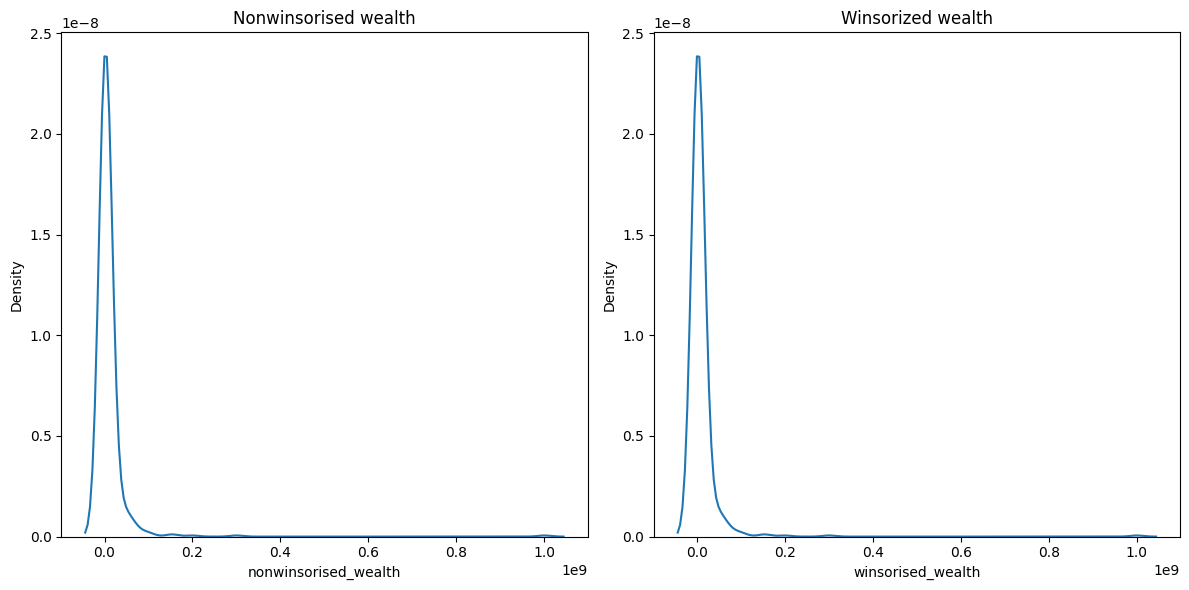

In [9]:
winsorized_wealth = winsorize_output(df0, "wealth", [0, 0])

In [10]:
# Using winsorised wealth as wealth
df0["wealth"] = winsorized_wealth

## Questions

In [11]:
df0.columns

Index(['responseid', 'Q1', 'Q2', 'Q3', 'Q4a', 'Q4.5_4', 'Q4.5_5', 'Q4.5_6',
       'Q5_1', 'Q6 - changed', 'Q8_1', 'Q8_2', 'Q8_3', 'Q8_4', 'Q8_5', 'Q8_6',
       'Q8_7', 'Q8_8', 'Q9b_1', 'Q9b_4', 'Q9b_10', 'Q9b_11', 'Q9b_12', 'Q9b_7',
       'Q9b_8', 'Q9b_13', 'Q9b_14', 'Q9b_9', 'Q14b', 'Q11a_1', 'Q11a_2',
       'Q11a_3', 'Q11b_1', 'Q11b_2', 'Q11b_3', 'Q11b_4', 'Q11b_5', 'Q11c',
       'Q11d', 'Q11h', 'Attention Check', 'Q11i', 'Q13a', 'Q13b', 'Q13c',
       'Q13d', 'Q12a', 'Q12b', 'Q12c', 'Q14a', 'Q14b.1', 'Q14c', 'Q54', 'Q57',
       'Q58', 'Q15a', 'psid', 'entrySigCheck', 'verification', 'age',
       'age_rec', 'isced', 'income', 'wealth', 'nonwinsorised_wealth',
       'winsorised_wealth'],
      dtype='object')

In [12]:
df0["q8_2_1"] = np.where(df0["Q11b_1"] == "No", 1, 2)
df0["q8_2_2"] = np.where(df0["Q11b_2"] == "No", 1, 2)
df0["q8_2_3"] = np.where(df0["Q11b_3"] == "No", 1, 2)
df0["q8_2_4"] = np.where(df0["Q11b_4"] == "No", 1, 2)
df0["q8_2_5"] = np.where(df0["Q11b_5"] == "No", 1, 2)

df0["q8_3"] = np.where(df0["Q11c"] == "The lower the quality of the study, the more likely that future studies will change the risk estimate.", 1,
                          np.where(df0["Q11c"] == "The higher the quality of the study, the more likely that future studies will change the risk estimate.", 2,
                                  np.where(df0["Q11c"] == "Irrespective of the quality of the study, future studies will not change the risk estimate.", 3,
                                          np.where(df0["Q11c"] == "Irrespective of the quality of the study, future studies will change the risk estimate substantially anyway.", 4,0
                                                  )
                                          )
                                  )
                         )


df0["q8_4"] = np.where(df0["Q11d"] == "The growth rate will be 0.4% on average each year", 1,
                          np.where(df0["Q11d"] == "The growth rate over five years will be exactly 2%", 2,
                                  np.where(df0["Q11d"] == "The growth rate over five years will be between 1% and 3%", 3,
                                          np.where(df0["Q11d"] == "It is not possible to predict the growth rate with certainty", 4,0
                                                  )
                                          )
                                  )
                         )

In [13]:
df0["q8_5berlin_1"] = np.where(df0["Q11a_1"].astype(int) == 1, 1, 2)
df0["q8_5london_1"] = np.where(df0["Q11a_1"].astype(int) == 1, 1, 2)
df0["q8_5paris_1"] = np.where(df0["Q11a_1"].astype(int) == 1, 1, 2)

df0["q8_6"] = np.where(df0["Q11i"] == "The medication increases recovery by 100%", 1,
                          np.where(df0["Q11i"] == "The medication increases recovery by 50%", 2,
                                   np.where(df0["Q11i"] == "The medication increases recovery by 2%", 3,
                                            np.where(df0["Q11i"] == "None of the above is implied", 4, 0
                                                    )
                                           )
                                  )
                         )

df0["q8_7"] = np.where(df0["Q11h"] == "5 in 100 people prior to the intervention to 6 out of 100 people after the intervention", 1,
                          np.where(df0["Q11h"] == "100 in 10,000 people prior to the intervention to 120 out of 10,000 people after the intervention", 2,
                                   np.where(df0["Q11h"] == "70 in 100 people prior to the intervention to 90 out of 100 people after the intervention", 3,
                                            np.where(df0["Q11h"] == "It is not possible to determine which of the answers is correct given the information provided", 4, 0
                                                    )
                                           )
                                  )
                         )


df0["q9_1_1"] = df0["Q14a"].astype(float).copy()
df0["q9_2_1"] = df0["Q14b.1"].astype(float).copy()

df0["q9_3"] = np.where(df0["Q14c"] == "Crosicol", 1,
                          np.where(df0["Q14c"] == "Hertinol", 2,
                                   np.where(df0["Q14c"] == "They are equal", 3,
                                            np.where(df0["Q14c"] == "Can’t say", 4, 0
                                                    )
                                           )
                                  )
                         )

In [14]:
df0["q10_1_1"] = df0["Q13a"].astype(float).copy()
df0["q10_2_1"] = df0["Q13b"].astype(float).copy()
df0["q10_3_1"] = df0["Q13c"].astype(float).copy()

df0["q10_4"] = np.where(df0["Q13d"] == "9 out of 59", 1,
                          np.where(df0["Q13d"] == "9 out of 10", 2,
                                   np.where(df0["Q13d"] == "59 out of 1000", 3,
                                            np.where(df0["Q13d"] == "59 out of 100", 4, 0
                                                    )
                                           )
                                  )
                         )

In [15]:
# Dynata Only

further_analysis_cols = [
    "Q5_1", "Q6 - changed",
    "Q8_1", "Q8_2", "Q8_3", "Q8_4", "Q8_5", "Q8_6", "Q8_7", "Q8_8",
    "Q9b_1", "Q9b_4", "Q9b_10", "Q9b_11", "Q9b_12",
    "Q9b_7", "Q9b_8", "Q9b_13", "Q9b_14",
    "Q12a", "Q12b", "Q12c"
    ] # not used


df0["Q5_1"] = df0["Q5_1"].astype(str)
df0["Q5_score"] = np.where(df0["Q5_1"] == "0 (unwilling to take risk)", 0,
                           np.where(df0["Q5_1"] == "1", 1,
                                    np.where(df0["Q5_1"] == "2", 2,
                                             np.where(df0["Q5_1"] == "3", 3,
                                                  np.where(df0["Q5_1"] == "4", 4,
                                                           np.where(df0["Q5_1"] == "5", 5,
                                                                    np.where(df0["Q5_1"] == "6", 6,
                                                                             np.where(df0["Q5_1"] == "7 (willing to take risk)", 7, -1
                                                                                      )
                                                                             )
                                                                    )
                                                           )
                                                      )
                                             )
                                    )
                           )

df0["Q6 - changed"] = df0["Q6 - changed"].astype(str)
df0["Q6_score"] = np.where(df0["Q6 - changed"] == "Definitely no experience", 0,
                           np.where(df0["Q6 - changed"] == "Rather little experience", 1,
                                        np.where(df0["Q6 - changed"] == "Some experience", 2,
                                                 np.where(df0["Q6 - changed"] == "Rather much experience", 3,
                                                          np.where(df0["Q6 - changed"] == "Definitely very much experience", 4, -1
                                                                   )
                                                          )
                                                 )
                                        )
                           )

cols = ["Q8_1", "Q8_2", "Q8_3", "Q8_4", "Q8_5", "Q8_6", "Q8_7", "Q8_8"]
df0[cols] = df0[cols].astype(int)
df0["Q8_total"] = df0[cols].sum(axis = 1)

cols = ["Q9b_1", "Q9b_4", "Q9b_10", "Q9b_11", "Q9b_12"]
df0[cols] = df0[cols].astype(float)
df0["Q9_safe_total"] = df0[cols].sum(axis = 1)

cols = ["Q9b_7", "Q9b_8", "Q9b_13", "Q9b_14", "Q9b_9"]
df0[cols] = df0[cols].astype(float)
df0["Q9_risky_total"] = df0[cols].sum(axis = 1)


cols = ["Q12a", "Q12b", "Q12c"]
df0[cols] = df0[cols].astype("string")

df0["Q12a_score"] = np.where(df0["Q12a"] == "More than INR 102", 1, 0)
df0["Q12b_score"] = np.where(df0["Q12b"] == "Less than today with the money in this account", 1, 0)
df0["Q12c_score"] = np.where(df0["Q12c"] == "False", 1, 0)

cols = ["Q12a_score", "Q12b_score", "Q12c_score"]
df0["Q12_total"] = df0[cols].sum(axis = 1)


cols = ["Q54", "Q57", "Q58"]
df0[cols] = df0[cols].astype(float)

df0["Q54_score"] = np.where((df0["Q54"] == 5) | (df0["Q54"] == 0.05), 1, 0)
df0["Q57_score"] = np.where(df0["Q57"] == 5, 1, 0)
df0["Q58_score"] = np.where(df0["Q58"] == 47, 1, 0)

cols = ["Q54_score", "Q57_score", "Q58_score"]
df0["crt_total"] = df0[cols].sum(axis = 1)

In [16]:
df0

,responseid,Q1,Q2,Q3,Q4a,Q4.5_4,Q4.5_5,Q4.5_6,Q5_1,Q6 - changed,Q8_1,Q8_2,Q8_3,Q8_4,Q8_5,Q8_6,Q8_7,Q8_8,Q9b_1,Q9b_4,Q9b_10,Q9b_11,Q9b_12,Q9b_7,Q9b_8,Q9b_13,Q9b_14,Q9b_9,Q14b,Q11a_1,Q11a_2,Q11a_3,Q11b_1,Q11b_2,Q11b_3,Q11b_4,Q11b_5,Q11c,Q11d,Q11h,Attention Check,Q11i,Q13a,Q13b,Q13c,Q13d,Q12a,Q12b,Q12c,Q14a,Q14b.1,Q14c,Q54,Q57,Q58,Q15a,psid,entrySigCheck,verification,age,age_rec,isced,income,wealth,nonwinsorised_wealth,winsorised_wealth,q8_2_1,q8_2_2,q8_2_3,q8_2_4,q8_2_5,q8_3,q8_4,q8_5berlin_1,q8_5london_1,q8_5paris_1,q8_6,q8_7,q9_1_1,q9_2_1,q9_3,q10_1_1,q10_2_1,q10_3_1,q10_4,Q5_score,Q6_score,Q8_total,Q9_safe_total,Q9_risky_total,Q12a_score,Q12b_score,Q12c_score,Q12_total,Q54_score,Q57_score,Q58_score,crt_total
0,0,Male,30,Post-Graduate Program,Salaried,Financial,Health,Politics,5,Rather much experience,5,5,5,6,6,6,5,6,25.0,15.0,10.0,0.0,0.0,15.0,15.0,15.0,5.0,0.0,5000000,2,1,2,No,Yes,Yes,No,No,"The higher the quality of the study, the more ...",The growth rate over five years will be betwee...,70 in 100 people prior to the intervention to ...,Vase,The medication increases recovery by 50%,500,100,1,9 out of 59,More than INR 102,Exactly the same as today with the money in th...,False,50,20,They are equal,0.10,5.0,12.0,"INR 500,001 – INR 15,00,000",HlYpErnBRElfITABy2UB4w**,on,success,30.0,2,1,2,5000000.0,5000000.0,5000000.0,1,2,2,1,1,2,3,2,2,2,2,3,50.0,20.0,3,500.0,100.0,1.000,1,5,3,44,50.0,50.0,1,0,1,2,0,1,0,1
1,1,Male,53,Post-Graduate Program,Salaried,unemployment,global warming,terrorism,5,Some experience,4,2,2,5,5,5,4,6,10.0,10.0,0.0,0.0,0.0,10.0,0.0,40.0,20.0,10.0,9000000,1,2,2,Yes,Yes,Yes,Yes,No,"Irrespective of the quality of the study, futu...",The growth rate over five years will be betwee...,"100 in 10,000 people prior to the intervention...",Vase,None of the above is implied,250,100,10,9 out of 59,More than INR 102,Less than today with the money in this account,False,25,10,Hertinol,0.10,5.0,3.0,"INR 30,00,001 – INR 50,00,000",HlYpErnBREl6Zv3o639IQg**,on,success,53.0,3,1,4,9000000.0,9000000.0,9000000.0,2,2,2,2,1,4,3,1,1,1,4,2,25.0,10.0,2,250.0,100.0,10.000,1,5,2,33,20.0,80.0,1,1,1,3,0,1,0,1
2,2,Male,32,Undergraduate Program,Salaried,Make my business,Personal finance,Health issues,7 (willing to take risk),Definitely very much experience,6,5,5,6,6,5,6,6,10.0,5.0,5.0,5.0,0.0,40.0,5.0,0.0,20.0,10.0,8000000,2,1,1,No,Yes,Yes,Yes,Yes,"Irrespective of the quality of the study, futu...",The growth rate will be 0.4% on average each year,5 in 100 people prior to the intervention to 6...,Vase,The medication increases recovery by 2%,500,10,0.1,9 out of 10,More than INR 102,Less than today with the money in this account,False,25,40,Hertinol,0.10,1.0,24.0,"INR 1500,001 – INR 30,00,000",HlYpErnBREkWR6uY4NFFuQ**,on,success,32.0,2,2,3,8000000.0,8000000.0,8000000.0,1,2,2,2,2,3,1,2,2,2,3,1,25.0,40.0,2,500.0,10.0,0.100,2,7,4,45,25.0,75.0,1,1,1,3,0,0,0,0
3,3,Female,31,Post-Graduate Program,Salaried,economy,job security,gender equality,6,Definitely very much experience,4,5,4,5,6,6,5,5,20.0,25.0,5.0,10.0,6.0,5.0,5.0,15.0,9.0,0.0,35000000,1,1,1,Yes,Yes,Yes,No,No,"The lower the quality of the study, the more l...",The growth rate over five years will be betwee...,"100 in 10,000 people prior to the intervention...",Vase,The medication increases recovery by 50%,500,1000,1,9 out of 10,More than INR 102,More than today with the money in this account,True,25,60,Crosicol,1.00,100.0,24.0,"INR 1500,001 – INR 30,00,000",HlYpErnBREnfC_DVlvW1bQ**,on,success,31.0,2,1,3,35000000.0,35000000.0,35000000.0,2,2,2,1,1,1,3,1,1,1,2,2,25.0,60.0,1,500.0,1000.0,1.000,2,6,4,40,66.0,34.0,1,0,0,1,0,0,0,0
4,4,Female,44,Post-Graduate Program,Salaried,Financial,Climate,Inflation,5,Rather much experience,6,5,5,6,6,5,6,6,5.0,25.0,0.0,5.0,10.0,15.0,30.0,10.0,0.0,0.0,40000000,1,2,1,Yes,Yes,Yes,Yes,No,"Irrespective of the quality of the study, futu...",The growth rate over five years will be betwee...,70 in 100 people prior to the intervention to ...,Vase,None of the above is impl

In [17]:
df0["Q12c"].value_counts()

Q12c
False               263
True                177
Do not know          47
Refuse to answer      3
Name: count, dtype: Int64

## SCORING

In [18]:
focal_col = ["q8_2_1", "q8_2_2", "q8_2_3", "q8_2_4", "q8_2_5",
             "q8_3", "q8_4",
             "q8_5berlin_1", "q8_5london_1", "q8_5paris_1", "q8_6", "q8_7",
             "q9_1_1", "q9_2_1", "q9_3",
             "q10_1_1", "q10_2_1", "q10_3_1", "q10_4"]

for col in focal_col:
    df0[col] = df0[col].astype(float)

scoreColumns = ["certainty1", "certainty2", "certainty3", "certainty4", "certainty5",
"uncertainty1", "uncertainty2",
"numeracy1", "numeracy2", "numeracy3", "numeracy4", "numeracy5",
"graph1", "graph2", "graph3",
"riskcomprehension1", "riskcomprehension2", "riskcomprehension3", "riskcomprehension4", "riskcomprehension5",
"bayesian1"
]

# Dynata Only
req_cols = [
    "riskappetite1", "riskappetite2","financialhabits",
    "riskyassets_%", "safeassets_%",
    "financialliteracy", "crtscore"]

df0[scoreColumns + req_cols] = 0

In [19]:
# Assigning scores

def scoring1(surveyFacet):
    surveyFacet.loc[ surveyFacet["q8_2_1"] == 2, "certainty1"] = 1
    surveyFacet.loc[ surveyFacet["q8_2_2"] == 2, "certainty2"] = 1
    surveyFacet.loc[ surveyFacet["q8_2_3"] == 2, "certainty3"] = 1
    surveyFacet.loc[ surveyFacet["q8_2_4"] == 2, "certainty4"] = 1
    surveyFacet.loc[ surveyFacet["q8_2_5"] == 2, "certainty5"] = 1

    surveyFacet.loc[ surveyFacet["q8_3"] == 1, "uncertainty1"] = 1
    surveyFacet.loc[ surveyFacet["q8_4"] == 4, "uncertainty2"] = 1

    surveyFacet.loc[ surveyFacet["q8_5berlin_1"] == 2, "riskcomprehension1"] = 1
    surveyFacet.loc[ surveyFacet["q8_5london_1"] == 1, "riskcomprehension2"] = 1
    surveyFacet.loc[ surveyFacet["q8_5paris_1"] == 1, "riskcomprehension3"] = 1
    
    surveyFacet.loc[ surveyFacet["q8_6"] == 1, "riskcomprehension4"] = 1
    surveyFacet.loc[ surveyFacet["q8_7"] == 4, "riskcomprehension5"] = 1

    surveyFacet.loc[ surveyFacet["q9_1_1"] == 25, "graph1"] = 1
    surveyFacet.loc[ surveyFacet["q9_2_1"] == 20, "graph2"] = 1
    surveyFacet.loc[ surveyFacet["q9_3"] == 3, "graph3"] = 1

    surveyFacet.loc[ surveyFacet["q10_1_1"] == 500, "numeracy1"] = 1
    surveyFacet.loc[ surveyFacet["q10_2_1"] == 10, "numeracy2"] = 1
    surveyFacet.loc[ (surveyFacet["q10_3_1"] == 0.1) | (surveyFacet["q10_3_1"] == ".1") | (surveyFacet["q10_3_1"] == ",1") , "numeracy3"] = 1
    surveyFacet.loc[ surveyFacet["q10_4"] == 1, "bayesian1"] = 1

    # Dynata Only
    surveyFacet.loc[:, "riskappetite1"] = surveyFacet["Q5_score"]
    surveyFacet.loc[:, "riskappetite2"] = surveyFacet["Q6_score"]
    
    surveyFacet.loc[:, "financialhabits"] = surveyFacet["Q8_total"]

    surveyFacet.loc[:, "riskyassets_%"] = surveyFacet["Q9_risky_total"]
    surveyFacet.loc[:, "safeassets_%"] = surveyFacet["Q9_safe_total"]
    
    surveyFacet.loc[:, "financialliteracy"] = surveyFacet["Q12_total"]

    surveyFacet.loc[:, "crtscore"] = surveyFacet["crt_total"]

    
    # Assigning total scores
    # surveyFacet["Certainty score_5"] = surveyFacet["certainty1"] + surveyFacet["certainty2"] + surveyFacet["certainty3"] + surveyFacet["certainty4"] + surveyFacet["certainty5"]
    #surveyFacet["Uncertainty score_5"] = surveyFacet["uncertainty1"] + surveyFacet["uncertainty2"]

    #surveyFacet["Number Comprehension score_5"] = surveyFacet["numeracy1"] + surveyFacet["numeracy2"] + surveyFacet["numeracy3"] + surveyFacet["numeracy4"] + surveyFacet["numeracy5"]
    #surveyFacet["Graph Comprehension score_5"] = surveyFacet["graph1"] + surveyFacet["graph2"] + surveyFacet["graph3"]

    #surveyFacet["Calculation score_4"] = surveyFacet["riskcalculation1"] + surveyFacet["riskcalculation2"] + surveyFacet["riskcalculation3"] + surveyFacet["riskcalculation4"]

    #surveyFacet["Total Score_19"] = surveyFacet["Certainty score_5"] + surveyFacet["Uncertainty score_5"] + surveyFacet["Number Comprehension score_5"] + surveyFacet["Graph Comprehension score_5"] + surveyFacet["Calculation score_4"]

    return surveyFacet

In [20]:
df1 = df0.groupby(["responseid"]).progress_apply(scoring1)
df1 = df1.reset_index(drop = True).copy()

 96%|█████████▌| 469/490 [00:02<00:00, 215.94it/s]/home/leshleon/projects/Risk Literacy/.venv/lib/python3.12/site-packages/tqdm/std.py:917: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return getattr(df, df_function)(wrapper, **kwargs)
100%|██████████| 490/490 [00:03<00:00, 156.97it/s]


In [21]:
def scoring2(survey):
    
    survey["Certainty_5"] = survey["certainty1"] + survey["certainty2"] + survey["certainty3"] + survey["certainty4"] + survey["certainty5"]
    
    survey["Uncertainty_2"] = survey["uncertainty1"] + survey["uncertainty2"]
    
    survey["RiskComprehension_5"] = survey["riskcomprehension1"] + survey["riskcomprehension2"] + survey["riskcomprehension3"] + survey["riskcomprehension4"] + survey["riskcomprehension5"]
    
    survey["GraphLiteracy_3"] = survey["graph1"] + survey["graph2"] + survey["graph3"]
    
    survey["Numeracy_3"] = survey["numeracy1"] + survey["numeracy2"] + survey["numeracy3"]
    
    survey["Bayesianreasoning_1"] = survey["bayesian1"]
    
    survey["TotalScore_19"] = survey["Certainty_5"] + survey["Uncertainty_2"] + survey["RiskComprehension_5"] + survey["GraphLiteracy_3"] + survey["Numeracy_3"] + survey["Bayesianreasoning_1"]
    
    survey["Certainty_%"] = survey["Certainty_5"] / 5 * 100
    survey["Uncertainty_%"] = survey["Uncertainty_2"] / 2 * 100
    survey["RiskComprehension_%"] = survey["RiskComprehension_5"] / 5 * 100
    survey["GraphLiteracy_%"] = survey["GraphLiteracy_3"] / 3 * 100
    survey["Numeracy_%"] = survey["Numeracy_3"] / 3 * 100
    survey["Bayesianreasoning_%"] = survey["Bayesianreasoning_1"] / 1 * 100
    
    survey["TotalScore_%"] = survey["TotalScore_19"] / 19 * 100

    #Dynata Only
    survey["RiskAppetite1_7"] = survey["riskappetite1"]
    survey["RiskAppetite2_4"] = survey["riskappetite2"]
    
    survey["FinancialHabits_48"] = survey["financialhabits"]

    survey["RiskAssets_%"] = survey["riskyassets_%"]
    survey["SafeAssets_%"] = survey["safeassets_%"]
    
    survey["FinancialLiteracy_3"] = survey["financialliteracy"]

    survey["CRTScore_3"] = survey["crtscore"]

    survey["RiskAppetite1_%"] = survey["RiskAppetite1_7"] / 7 * 100
    survey["RiskAppetite2_%"] = survey["RiskAppetite2_4"] / 4 * 100
    survey["FinancialHabits_%"] = survey["FinancialHabits_48"] / 48 * 100
    survey["FinancialLiteracy_%"] = survey["FinancialLiteracy_3"] / 3 * 100
    survey["CRTScore_%"] = survey["CRTScore_3"] / 3 * 100
    
    
    colReq = [
        "responseid", "age", "age_rec", "isced", "income", "wealth", "Certainty_5", "Uncertainty_2", "RiskComprehension_5", "GraphLiteracy_3",
        "Numeracy_3", "Bayesianreasoning_1", "Certainty_%", "Uncertainty_%", "RiskComprehension_%", "GraphLiteracy_%", "Numeracy_%", "Bayesianreasoning_%",
        "TotalScore_19", "TotalScore_%",
        #Dynata only
        "RiskAssets_%", "SafeAssets_%",
        "RiskAppetite1_%", "RiskAppetite1_7", "RiskAppetite2_%", "RiskAppetite2_4",
        "FinancialHabits_%", "FinancialHabits_48",
        "FinancialLiteracy_%", "FinancialLiteracy_3",
        "CRTScore_3", "CRTScore_%"
    ]
    
    survey1 = survey[colReq].copy()
    return survey1

In [22]:
df2 = scoring2(df1)

In [23]:
main = df2.copy()

In [24]:
# will be used later
wealth_quartile = pd.qcut(main.loc[~ (main["wealth"]==-1)]["wealth"],q = 4, labels = False, duplicates = "raise" )

## Income Terciles and Quartiles

How to Form Terciles from Categorical Data

If your categorical data has a natural order (ordinal data), you can divide it into terciles—three groups each containing approximately one-third of the observations—by following these steps:
1. List the Categories in Order
Arrange your categories from lowest to highest based on their natural order.
2. Count Observations in Each Category
Determine the number of observations in each category.
3. Calculate Cumulative Percentages
For each category, calculate the cumulative percentage of observations up to and including that category.
4. Assign Tercile Groups:
The first tercile includes categories up to the point where the cumulative percentage reaches or exceeds 33.3%.
The second tercile includes categories up to the point where the cumulative percentage reaches or exceeds 66.7%.
The third tercile includes the remaining categories.
6. A single Tercile muct never exceed 50% of the sample. If a Tercile exceeds 50% of the sample then it needs to be split up for the price of the Cumulative percentage being lower than 33.3% per Tercile.

How to Form Quartiles from Categorical Data

If your categorical data has a natural order (ordinal data), you can divide it into quartiles—three groups each containing approximately one-third of the observations—by following these steps:
1. List the Categories in Order
Arrange your categories from lowest to highest based on their natural order.
2. Count Observations in Each Category
Determine the number of observations in each category.
3. Calculate Cumulative Percentages
For each category, calculate the cumulative percentage of observations up to and including that category.
4. Assign Quartile Groups:
The first quartile includes categories up to the point where the cumulative percentage reaches or exceeds 25%.
The second quartile includes categories up to the point where the cumulative percentage reaches or exceeds 50%.
The third quartile includes categories up to the point where the cumulative percentage reaches or exceeds 75%.
The fourth quartile includes the remaining categories.
6. A single Quartile muct never exceed 50% of the sample. If a Quartile exceeds 50% of the sample then it needs to be split up for the price of the Cumulative percentage being lower than 33.3% per Quartile.

In [25]:
16.309013 +  10.872675 + 7.439199

34.620887

In [26]:
main["income"].value_counts().sort_index() / len(main) * 100

income
1    21.020408
2    33.061224
3    17.551020
4    13.673469
5     7.959184
6     6.734694
Name: count, dtype: float64

### Income Terciles
1 - income = 1 --> 194 (194)

2 - income = 2 3 --> 335 (114 + 221)

3 - income = 4 5 6 --> 170 (76 + 52 + 42)

In [27]:
main["income_tercile"] = np.where(main["income"] == 1, 1,
                                  np.where(main["income"] == 2, 2,
                                           np.where(main["income"] == 3, 2,
                                                    np.where(main["income"] == 4, 3,
                                                             np.where(main["income"] == 5, 3,
                                                                      np.where(main["income"] == 6, 3, -1
                                                                              )
                                                                     )
                                                            )
                                                   )
                                          )
                                 )                                  

### Income Quartiles
1 - income = 1 --> 27.7 (27.7)

2 - income = 2 --> 31.6 (31.6)

3 - income = 3 4 --> 27.1 (16.3 + 10.8)

4 - income = 5 6 --> 13.4 (7.4 + 6.0)

In [28]:
main["income_quartile"] = np.where(main["income"] == 1, 1,
                                   np.where(main["income"] == 2, 2,
                                           np.where(main["income"] == 3, 3,
                                                    np.where(main["income"] == 4, 3,
                                                             np.where(main["income"] == 5, 4,
                                                                      np.where(main["income"] == 6, 4, -1
                                                                               )
                                                                      )
                                                             )
                                                    )
                                           )
                                   )   

--------------------------------------------------------------------------------------------------------------------

--------------------------------------------------------------------------------------------------------------------

In [29]:
#Global Vras:
facet_cols = ["Certainty_5", "Uncertainty_2", "RiskComprehension_5", "GraphLiteracy_3",
              "Numeracy_3", "Bayesianreasoning_1"]

facet_percent_cols = ["Certainty_%", "Uncertainty_%", "RiskComprehension_%", "GraphLiteracy_%",
                      "Numeracy_%", "Bayesianreasoning_%",]

# Study 2 - India Dynata

## Graph 1.0 - Total Score Frequency Distribution

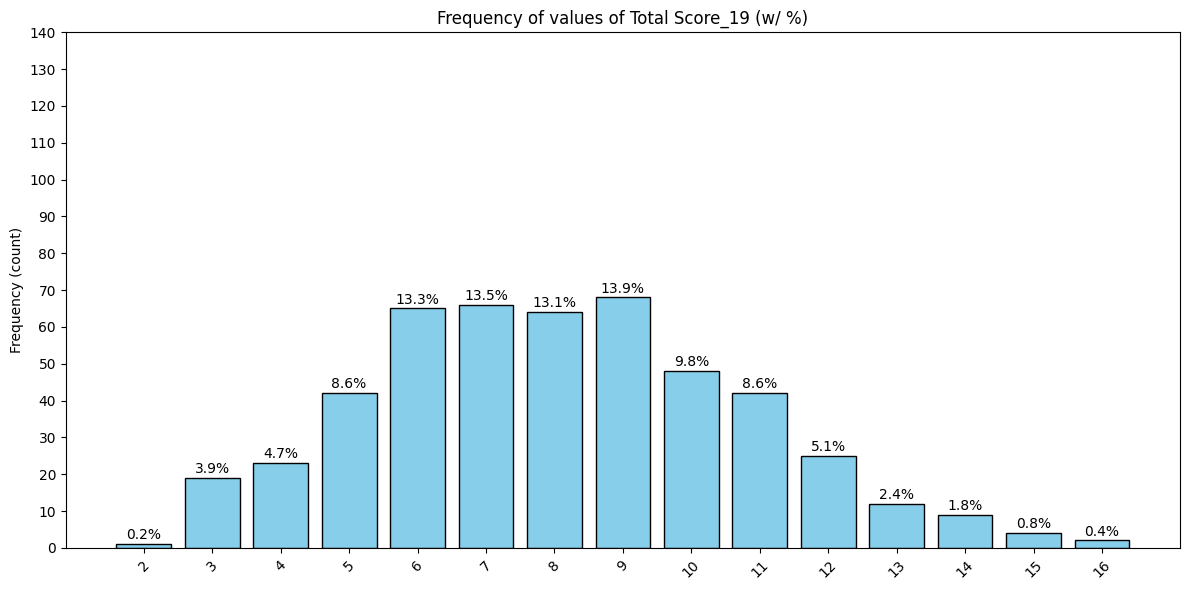

In [30]:
fig, axes = plt.subplots(1, 1, figsize = [12, 6])

sample = main["TotalScore_19"].value_counts().sort_index()
x = sample.index
y = sample.values
total = sample.sum()

axes.bar(x, y, color="skyblue", edgecolor='black')

for j, value in zip(sample.index, sample.values):
    axes.text(j, value + 0.5, f"{value/total * 100:.1f}%", ha = "center", va = "bottom", fontsize=10, color="black")

axes.set_yticks(np.arange(0, 150, step = 10))
axes.set_xticks(x)
axes.set_xticklabels(x, rotation = 45, ha = "center")

axes.set_ylabel(f"Frequency (count)")
axes.set_title(f"Frequency of values of Total Score_19 (w/ %)")

plt.tight_layout()
plt.show()

## Table 1.1 - Mean Total Score + SD

Text(0, 0.5, 'Mean Total score')

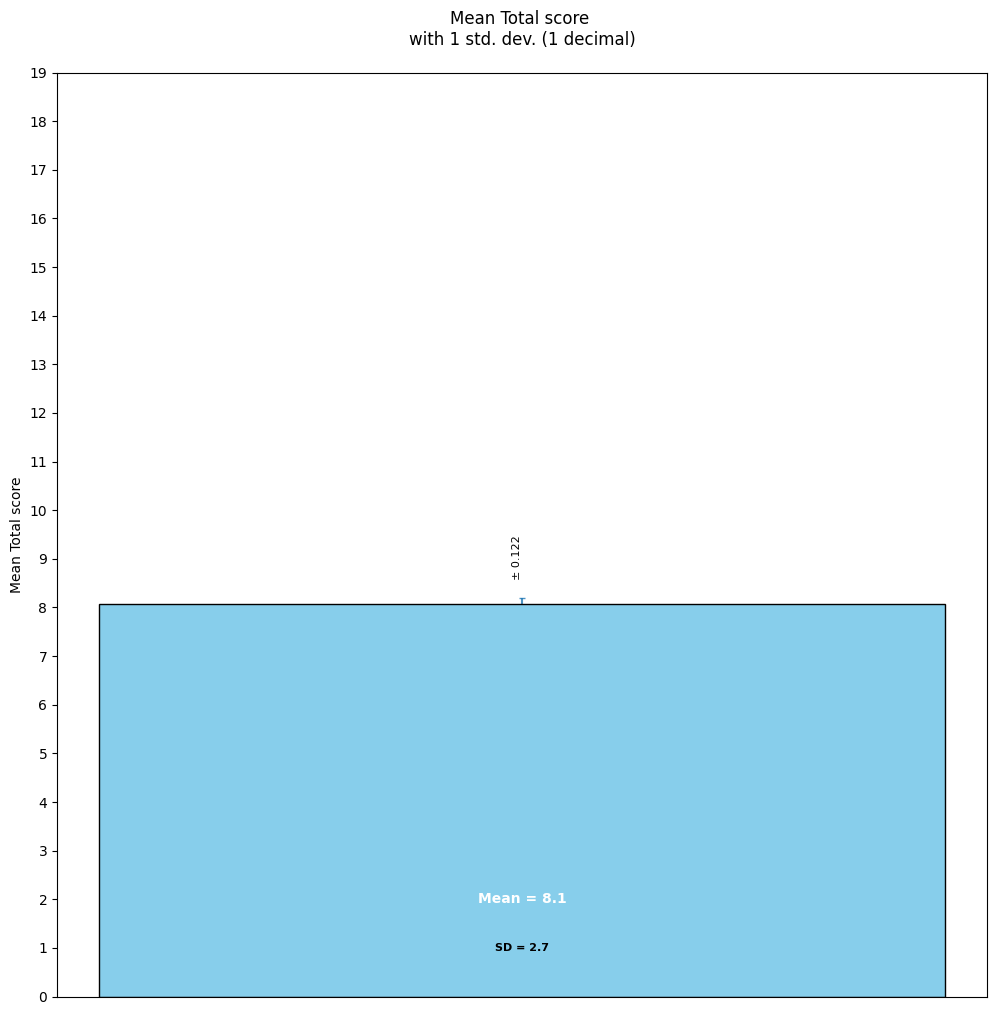

In [31]:
fig, axes = plt.subplots(1, 1, figsize = [12, 12])

mean = main["TotalScore_19"].mean()
std = main["TotalScore_19"].std()
sem = main["TotalScore_19"].sem()

axes.bar(1, mean, width = 0.8, color="skyblue", edgecolor='black')
axes.errorbar(1, mean, yerr = sem,
              fmt = "none", capsize = 2, alpha = 0.8, zorder = 0)

axes.set_yticks(np.arange(0, 20))
axes.set_xticks(np.arange(0, 0))
axes.tick_params(axis = "x", rotation = 45)


axes.text(1, mean + 0.5, f"± {sem:.3f}", ha = "right", va = "bottom", fontsize=8, color="black", rotation = 90)
axes.text(1, 2, f"Mean = {mean:.1f}", ha = "center", va = "center",
          color='white', fontsize=10, fontweight='bold')
axes.text(1, 1, f"SD = {std:.1f}", ha = "center", va = "center",
          color='black', fontsize=8, fontweight='bold')
    

axes.set_title("Mean Total score \nwith 1 std. dev. (1 decimal)", pad = 20)
axes.set_ylabel("Mean Total score")

----------------------------------

## Table 1.2 - Mean Facet Scores + SD (Ver. 1)

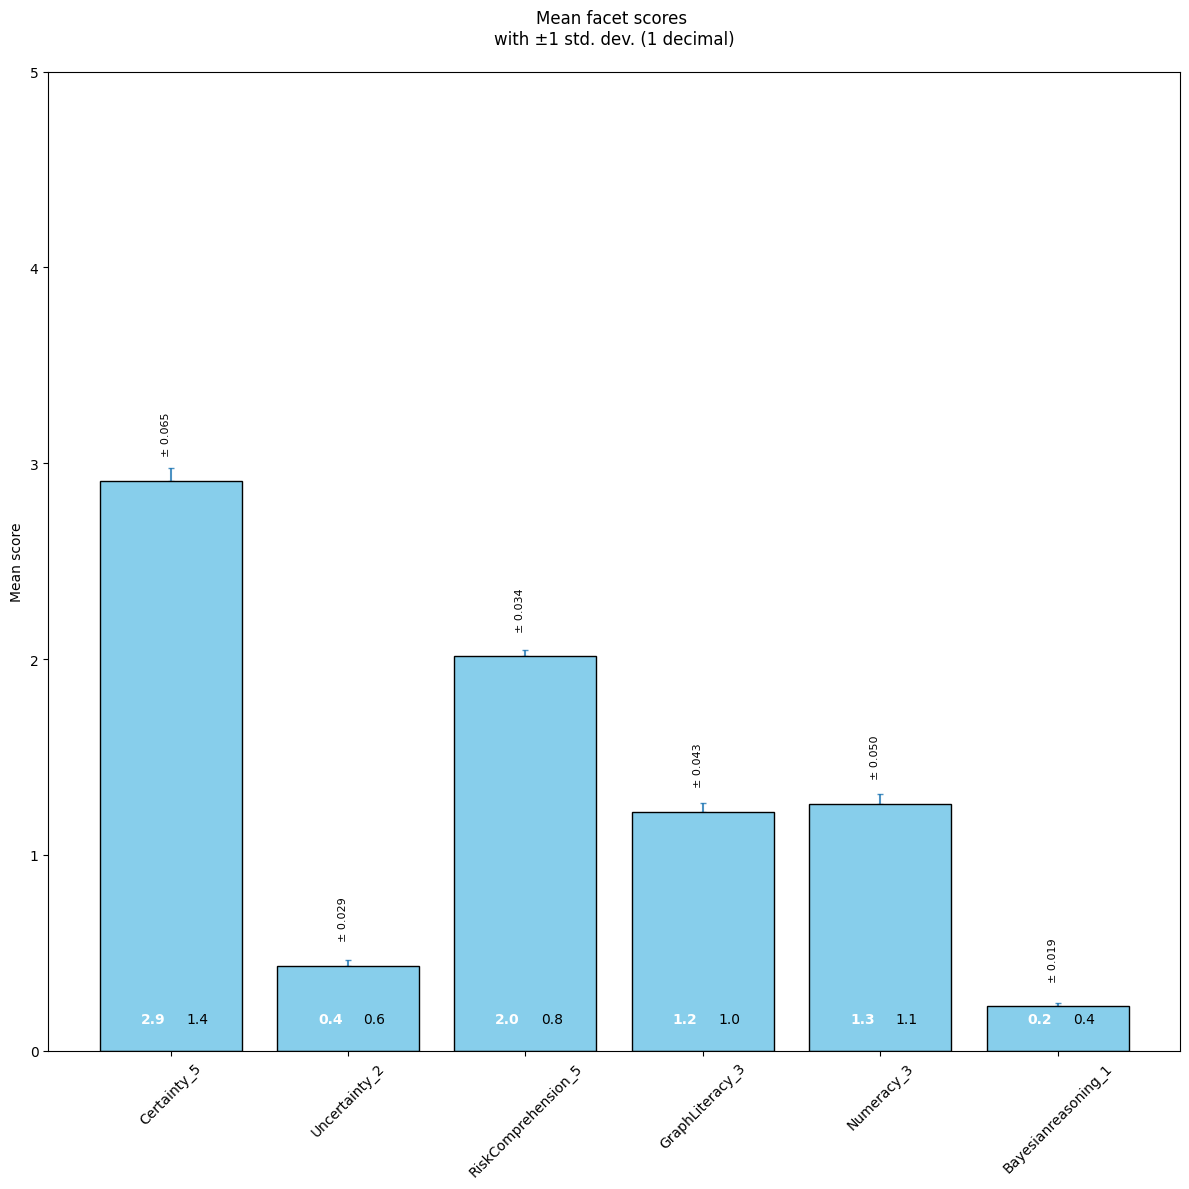

In [32]:
fig, axes = plt.subplots(1, 1, figsize = [12, 12])

mean_scores = main[facet_cols].mean()
std_scores = main[facet_cols].std().reindex(mean_scores.index)
sem_scores = main[facet_cols].sem().reindex(mean_scores.index)

axes.bar(mean_scores.index, mean_scores.values, color="skyblue", edgecolor='black')
axes.errorbar(mean_scores.index, mean_scores.values, yerr = [np.zeros_like(sem_scores), sem_scores],
              fmt = "none", capsize = 2, alpha = 0.8, zorder = 0)

y_max = 5
axes.set_yticks(np.arange(0, y_max + 1))
axes.tick_params(axis = "x", rotation = 45)

for j, (mean, std, sem) in enumerate(zip(mean_scores.values, std_scores.values, sem_scores.values)):
    axes.text(j, mean + 0.025 * y_max, f"± {sem:.3f}", ha = "right", va = "bottom", fontsize=8, color="black", rotation = 90)
    axes.text(j - 0.1, 0.025 * y_max, f"{mean:.1f}", ha = "center", va = "bottom",
              color='white', fontsize=10, fontweight='bold')
    axes.text(j + 0.15, 0.025 * y_max, f"{std:.1f}", ha = "center", va = "bottom",
              color='black', fontsize=10)

    

axes.set_title(f"Mean facet scores \nwith ±1 std. dev. (1 decimal)", pad = 20)
axes.set_ylabel(f"Mean score")


plt.tight_layout()
plt.show()

---

---

## Table 1.3 - M proportion of maximum (Total Score) score + SD + Median

Text(0, 0.5, 'Mean % score')

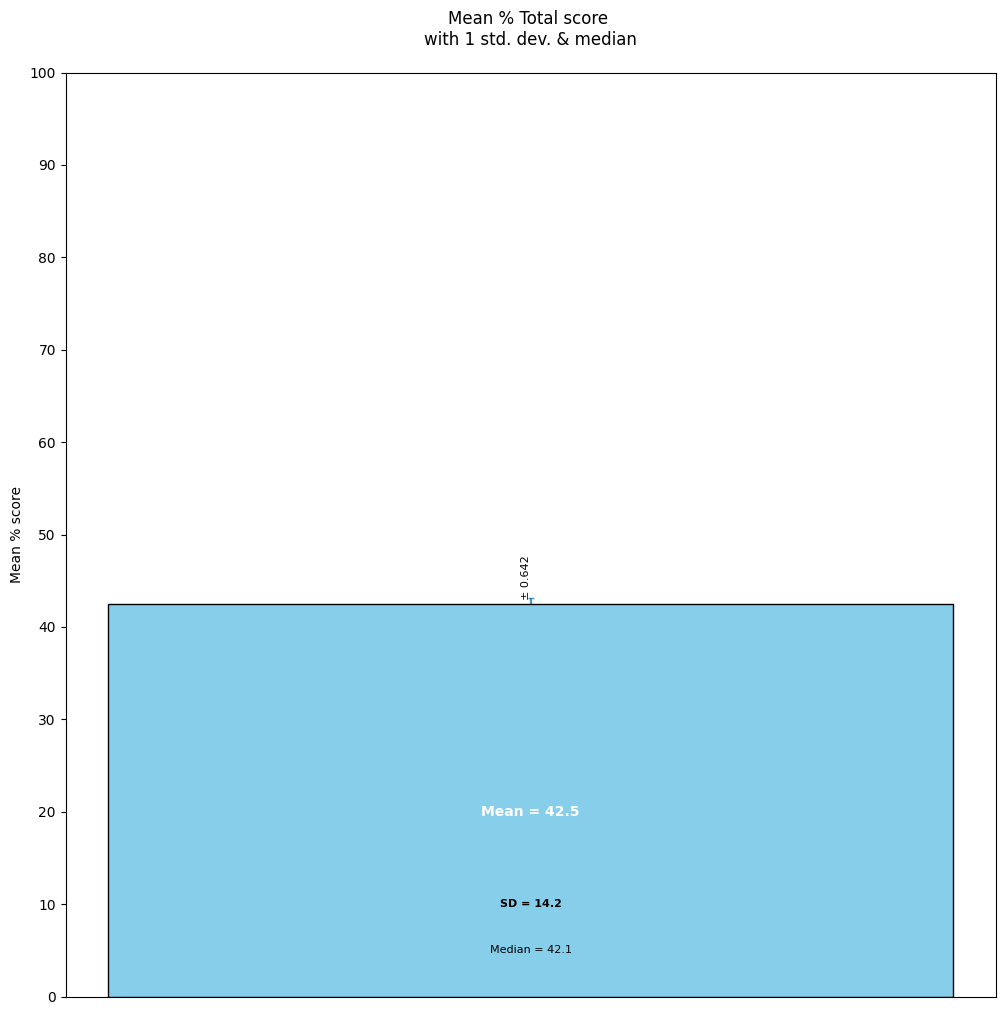

In [33]:
fig, axes = plt.subplots(1, 1, figsize = [12, 12])

mean = main["TotalScore_%"].mean()
std =  main["TotalScore_%"].std()
sem =  main["TotalScore_%"].sem()
med =  main["TotalScore_%"].median()

axes.bar(1, mean, width = 0.8, color="skyblue", edgecolor='black')
axes.errorbar(1, mean, yerr = sem,
              fmt = "none", capsize = 2, alpha = 0.8, zorder = 0)

axes.set_yticks(np.arange(0, 101, step = 10))
axes.set_xticks(np.arange(0, 0))
axes.tick_params(axis = "x", rotation = 45)

axes.text(1, mean + 0.5, f"± {sem:.3f}", ha = "right", va = "bottom", fontsize=8, color="black", rotation = 90)
axes.text(1, 20, f"Mean = {mean:.1f}", ha = "center", va = "center",
          color='white', fontsize=10, fontweight='bold')
axes.text(1, 10, f"SD = {std:.1f}", ha = "center", va = "center",
          color='black', fontsize=8, fontweight='bold')
axes.text(1, 5, f"Median = {med:.1f}", ha = "center", va = "center",
          color='black', fontsize=8)
    

axes.set_title("Mean % Total score \nwith 1 std. dev. & median", pad = 20)
axes.set_ylabel("Mean % score")

----------------------------------

## Table 1.4 - M proportion of Facet Scores + SD + Median

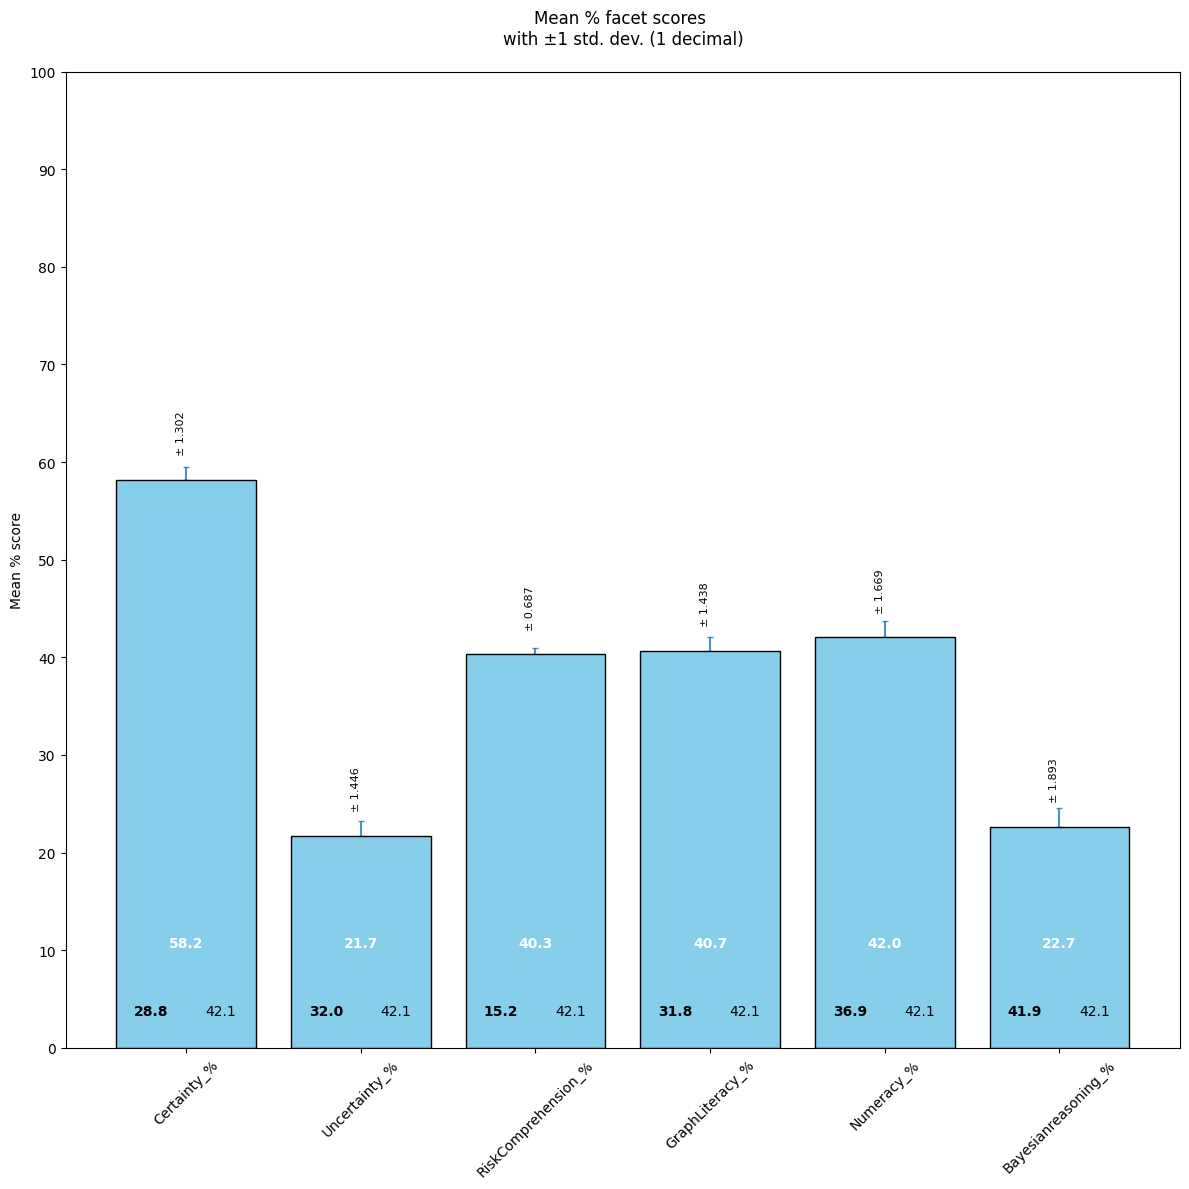

In [34]:
fig, axes = plt.subplots(1, 1, figsize = [12, 12])

mean_scores = main[facet_percent_cols].mean()
std_scores = main[facet_percent_cols].std().reindex(mean_scores.index)
sem_scores = main[facet_percent_cols].sem().reindex(mean_scores.index)
med_scores = main[facet_percent_cols].median().reindex(mean_scores.index)

axes.bar(mean_scores.index, mean_scores.values, color="skyblue", edgecolor='black')
axes.errorbar(mean_scores.index, mean_scores.values, yerr = [np.zeros_like(sem_scores), sem_scores],
              fmt = "none", capsize = 2, alpha = 0.8, zorder = 0)

y_max = 100
axes.set_yticks(np.arange(0, 101, step = 10))
axes.tick_params(axis = "x", rotation = 45)

for j, (mean, std, sem) in enumerate(zip(mean_scores.values, std_scores.values, sem_scores.values)):
    axes.text(j, mean + 0.025 * y_max, f"± {sem:.3f}", ha = "right", va = "bottom", fontsize=8, color="black", rotation = 90)
    axes.text(j, 0.1 * y_max, f"{mean:.1f}", ha = "center", va = "bottom",
              color='white', fontsize=10, fontweight='bold')
    axes.text(j - 0.2, 0.03 * y_max, f"{std:.1f}", ha = "center", va = "bottom",
              color='black', fontsize=10, fontweight='bold')
    axes.text(j + 0.2, 0.03 * y_max, f"{med:.1f}", ha = "center", va = "bottom",
                     color='black', fontsize=10)

    

axes.set_title(f"Mean % facet scores \nwith ±1 std. dev. (1 decimal)", pad = 20)
axes.set_ylabel(f"Mean % score")
plt.tight_layout()
plt.show()

---

---

## Table 2.1 - Per income class: Mean Facet Scores + SD + Median

Note: Income Class has been filtered out of entries who opted out of disclosing their income

In [35]:
income_filtered = main.loc[ ~(main["income"] == 0)].copy()
income_filtered.income.value_counts()

income
2    162
1    103
3     86
4     67
5     39
6     33
Name: count, dtype: int64

In [36]:
# fig, axes = plt.subplots(6, 1, figsize = [12, 6*6])

# income_classes = income_filtered.income.value_counts().sort_index().index.values

# for i, income_class in enumerate(income_classes):
#     sample = income_filtered.loc[ income_filtered["income"] == income_class].copy()
    
#     mean = sample["TotalScore_%"].mean()
#     std =  sample["TotalScore_%"].std()
#     sem =  sample["TotalScore_%"].sem()
#     med =  sample["TotalScore_%"].median()

#     axes[i].bar(1, mean, color="skyblue", edgecolor='black')
#     axes[i].errorbar(1, mean, yerr = [sem],
#                   fmt = "none", capsize = 2, alpha = 0.8, zorder = 0)

#     y_max = 100
#     axes[i].set_yticks(np.arange(0, 101, step = 20))
#     axes[i].tick_params(axis = "x", rotation = 45)
    
#     axes[i].text(1, mean + 0.5, f"± {sem:.3f}", ha = "right", va = "bottom", fontsize=8, color="black", rotation = 90)
#     axes[i].text(1, 20, f"Mean = {mean:.1f}", ha = "center", va = "center",
#               color='white', fontsize=10, fontweight='bold')
#     axes[i].text(1, 10, f"SD = {std:.1f}", ha = "center", va = "center",
#               color='black', fontsize=8, fontweight='bold')
#     axes[i].text(1, 5, f"Median = {med:.1f}", ha = "center", va = "center",
#               color='black', fontsize=8)
        
    
#     axes[i].set_title(f"Mean % Total score \nfor income class :{income_class}", pad = 20)
#     axes[i].set_ylabel("Mean % Total score")

# plt.tight_layout()
# plt.show()

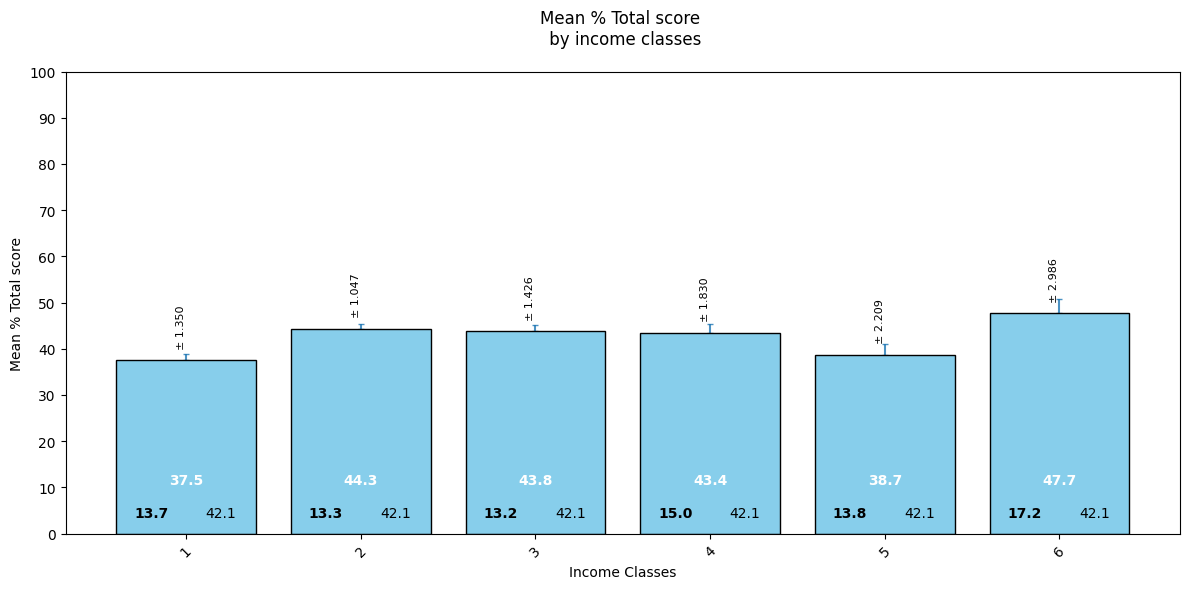

In [37]:
fig, axes = plt.subplots(1, 1, figsize = [12, 6])

income_classes = income_filtered.income.value_counts().sort_index().index.values

sample = main.loc[ ~(main["income"] == 0)].copy()

mean_scores = sample.groupby("income")["TotalScore_%"].mean().sort_index()
std_scores =  sample.groupby("income")["TotalScore_%"].std().reindex(mean_scores.index)
sem_scores =  sample.groupby("income")["TotalScore_%"].sem().reindex(mean_scores.index)
med_scores =  sample.groupby("income")["TotalScore_%"].median().reindex(mean_scores.index)

axes.bar(mean_scores.index, mean_scores.values, color="skyblue", edgecolor='black')
axes.errorbar(mean_scores.index, mean_scores.values, yerr = [np.zeros_like(sem_scores), sem_scores],
              fmt = "none", capsize = 2, alpha = 0.8, zorder = 0)

y_max = 100
axes.set_yticks(np.arange(0, 101, step = 10))
axes.tick_params(axis = "x", rotation = 45)

for j, (mean, std, sem) in enumerate(zip(mean_scores.values, std_scores.values, sem_scores.values)):
    axes.text(j+1, mean + 0.025 * y_max, f"± {sem:.3f}", ha = "right", va = "bottom", fontsize=8, color="black", rotation = 90)
    axes.text(j+1, 0.1 * y_max, f"{mean:.1f}", ha = "center", va = "bottom",
              color='white', fontsize=10, fontweight='bold')
    axes.text(j+1 - 0.2, 0.03 * y_max, f"{std:.1f}", ha = "center", va = "bottom",
              color='black', fontsize=10, fontweight='bold')
    axes.text(j+1 + 0.2, 0.03 * y_max, f"{med:.1f}", ha = "center", va = "bottom",
                     color='black', fontsize=10)
    

axes.set_title(f"Mean % Total score \n by income classes", pad = 20)
axes.set_ylabel("Mean % Total score")
axes.set_xlabel("Income Classes")

plt.tight_layout()
plt.show()

---

## Table 2.2 - Per income class: Mean Facet Scores

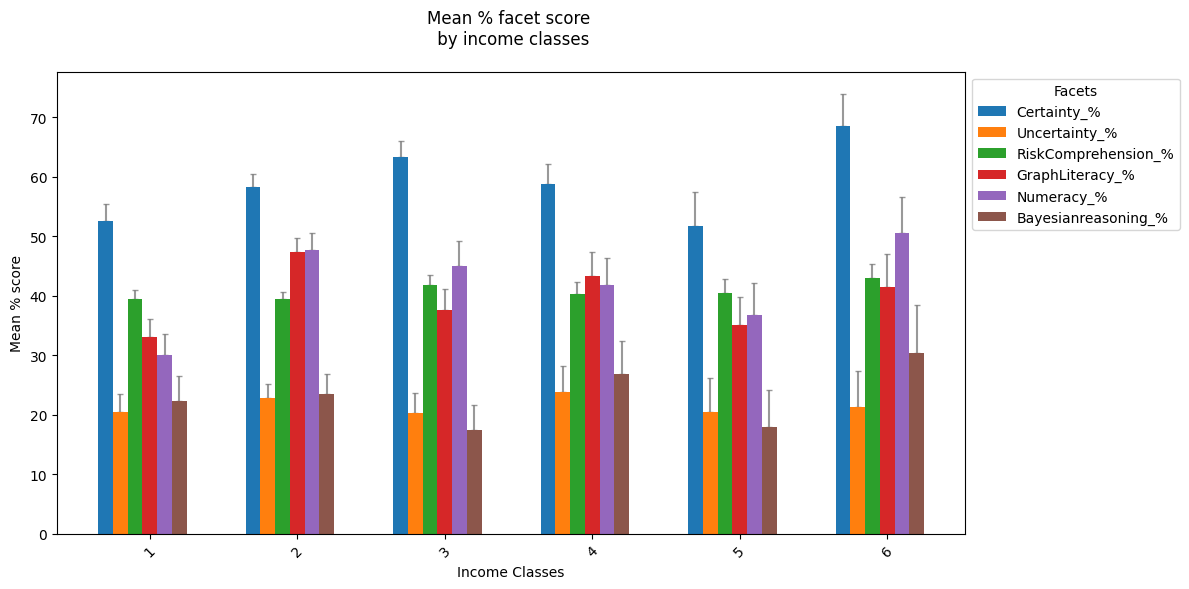

In [38]:
fig, axes = plt.subplots(1, 1, figsize = [12, 6])

income_classes = income_filtered.income.value_counts().sort_index().index.values

sample = main.loc[ ~(main["income"] == 0)].copy()

mean_scores = sample.groupby("income")[facet_percent_cols].mean().sort_index()
std_scores =  sample.groupby("income")[facet_percent_cols].std().reindex(mean_scores.index)
sem_scores =  sample.groupby("income")[facet_percent_cols].sem().reindex(mean_scores.index)
med_scores =  sample.groupby("income")[facet_percent_cols].median().reindex(mean_scores.index)

y_max = 100
axes.set_yticks(np.arange(0, 101, step = 10))
axes.tick_params(axis = "x", rotation = 45)

width = 0.1

for j, facet in enumerate(facet_percent_cols):
    mean_facet_scores = mean_scores[facet]
    sem_facet_scores = sem_scores[facet]

    offset = (- len(income_classes)/ 2 + j) * width
    axes.bar(income_classes + offset , mean_facet_scores, width, label = str(facet))
    axes.errorbar(income_classes + offset , mean_facet_scores, yerr = [np.zeros_like(sem_facet_scores), sem_facet_scores],
                  fmt = "none", capsize = 2.5, alpha = 0.8, zorder = 0, ecolor = "grey")


axes.set_title(f"Mean % facet score \n by income classes", pad = 20)
axes.set_ylabel("Mean % score")
axes.set_xlabel("Income Classes")
axes.legend(title="Facets", bbox_to_anchor=(1.0, 1))

plt.tight_layout()
plt.show()

---

---

## Table 3.1: (Countries pooled): Relationship to total sum score and controlling for education and age using income 

In [39]:
income_filtered = main.loc[ ~(main["income"] == 0)].copy()

risklit_quartile = pd.qcut(income_filtered["TotalScore_19"],q = 4, labels = False ) + 1
income_filtered["risklit_quartile"] = risklit_quartile.copy()

data = income_filtered.copy()

# Age group 2 = 18 to 35 y/o
# Age group 3 = 36 to 55 y/o
# Age group 4 = 56 to 75 y/o 

age_rec = [0] + sorted(data["age_rec"].unique())
age_dict = {0:"ALL Age", 2:"Only 18-35",
            3:"Only 36-55", 4:"Only 56+"}

In [40]:
# # fig, axes = plt.subplots(3, 1, figsize = [12, 4*6])
# # axes = axes.flatten()

# for i, age_class in enumerate(age_rec):
#     if age_class == 0:
#         sample = data.copy()
#     else:
#         sample = data.loc[ data["age_rec"] == age_class].copy()
#     sample_ready = sample.groupby("risklit_quartile")["income"].value_counts().to_frame().sort_index()
#     sample_ready = sample_ready.unstack(level = "income")
#     sample_ready.columns = sample_ready.columns.droplevel(0)
#     sample_ready.plot(kind='bar', stacked=True)

#     plt.ylabel("count each risk literacy quartile")
#     plt.xlabel("Risk quartile")
#     plt.title(f"Stacked bar chart: {age_dict[age_class]}")
#     plt.legend(title="Income class", bbox_to_anchor=(1, 1))
    
# plt.show()

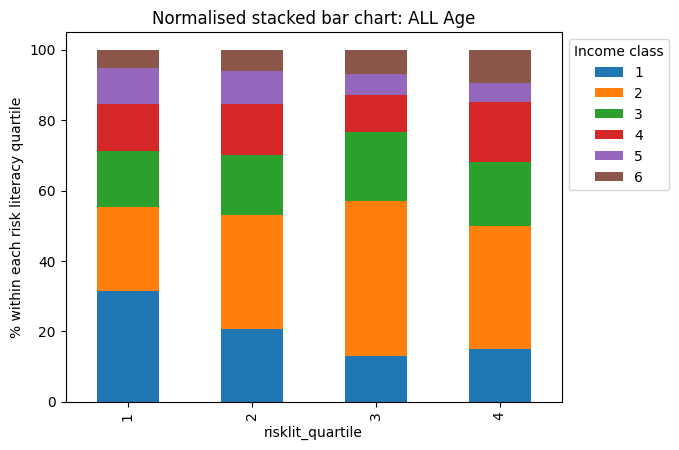

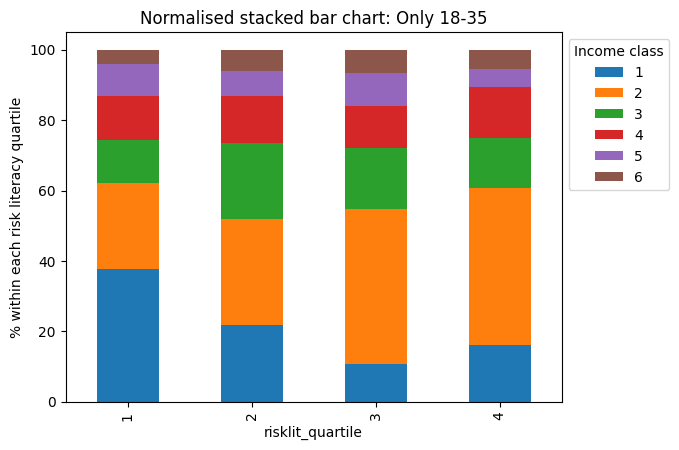

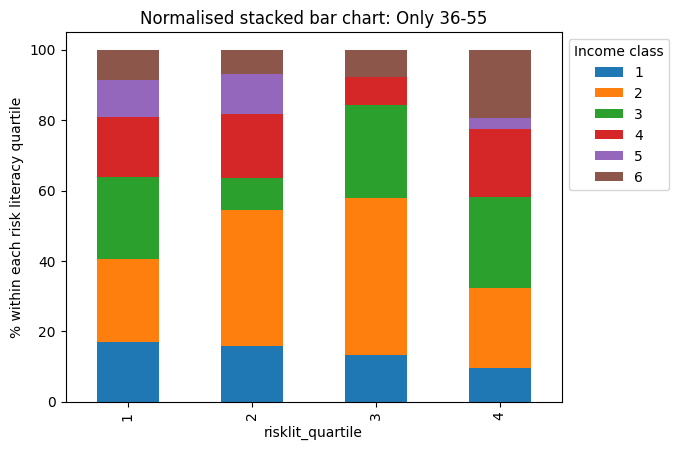

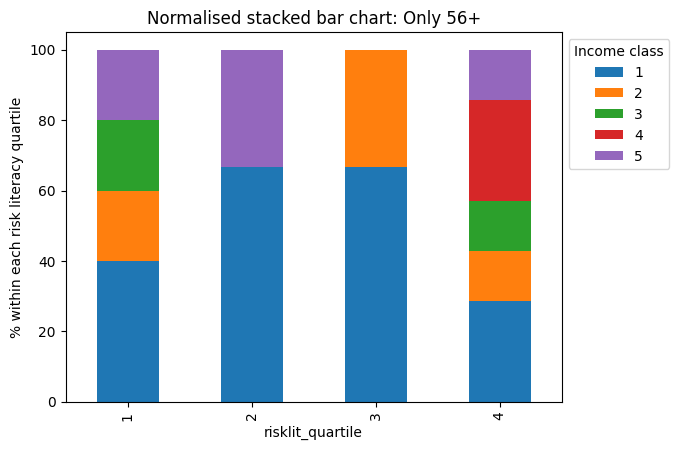

In [41]:
# fig, axes = plt.subplots(3, 1, figsize = [12, 4*6])
# axes = axes.flatten()

for i, age_class in enumerate(age_rec):
    if age_class == 0:
        sample = data.copy()
    else:
        sample = data.loc[ data["age_rec"] == age_class].copy()
    sample_ready = sample.groupby("risklit_quartile")["income"].value_counts().to_frame().sort_index()
    sample_ready = sample_ready.unstack(level = "income")
    sample_ready.columns = sample_ready.columns.droplevel(0)
    sample_ready = sample_ready.div(sample_ready.sum(axis = 1), axis = 0)*100
    sample_ready.plot(kind='bar', stacked=True)

    plt.ylabel("% within each risk literacy quartile")
    plt.title(f"Normalised stacked bar chart: {age_dict[age_class]}")
    plt.legend(title="Income class", bbox_to_anchor=(1, 1))
    
plt.show()

---

---

---

---

## Table 4.1 - Per country per wealth quartile: M proportion of maximum score + SD + Median facet scores

Note: Wealth Class has been filtered out of entries who opted out of disclosing their income, and a quartile on the resulting data has been created

In [42]:
wealth_filtered = main.loc[ ~(pd.isnull(main["wealth"]))].copy().reset_index()
wealth_quartile = pd.qcut(wealth_filtered["wealth"],q = 4, labels = False, duplicates = "raise") + 1
wealth_filtered["wealth_quartile"] = wealth_quartile.copy()

In [43]:
# fig, axes = plt.subplots(4, 1, figsize = [12, 6*4])

# wealth_quartiles = sorted(wealth_filtered["wealth_quartile"].unique())

# for i, wealth_quartile in enumerate(wealth_quartiles):
#     sample = wealth_filtered.loc[ wealth_filtered["wealth_quartile"] == wealth_quartile].copy()
    
#     mean = sample["TotalScore_%"].mean()
#     std =  sample["TotalScore_%"].std()
#     sem =  sample["TotalScore_%"].sem()
#     med =  sample["TotalScore_%"].median()

#     axes[i].bar(1, mean, color="skyblue", edgecolor='black')
#     axes[i].errorbar(1, mean, yerr = sem,
#                   fmt = "none", capsize = 2, alpha = 0.8, zorder = 0)

#     y_max = 100
#     axes[i].set_yticks(np.arange(0, 101, step = 20))
#     axes[i].tick_params(axis = "x", rotation = 45)
    
#     axes[i].text(1, mean + 0.5, f"± {sem:.3f}", ha = "right", va = "bottom", fontsize=8, color="black", rotation = 90)
#     axes[i].text(1, 20, f"Mean = {mean:.1f}", ha = "center", va = "center",
#               color='white', fontsize=10, fontweight='bold')
#     axes[i].text(1, 10, f"SD = {std:.1f}", ha = "center", va = "center",
#               color='black', fontsize=8, fontweight='bold')
#     axes[i].text(1, 5, f"Median = {med:.1f}", ha = "center", va = "center",
#               color='black', fontsize=8)
        
    
#     axes[i].set_title(f"Mean % Total score \nfor wealth quartile :Q{wealth_quartile}", pad = 20)
#     axes[i].set_ylabel("Mean % Total score")

# plt.tight_layout()
# plt.show()

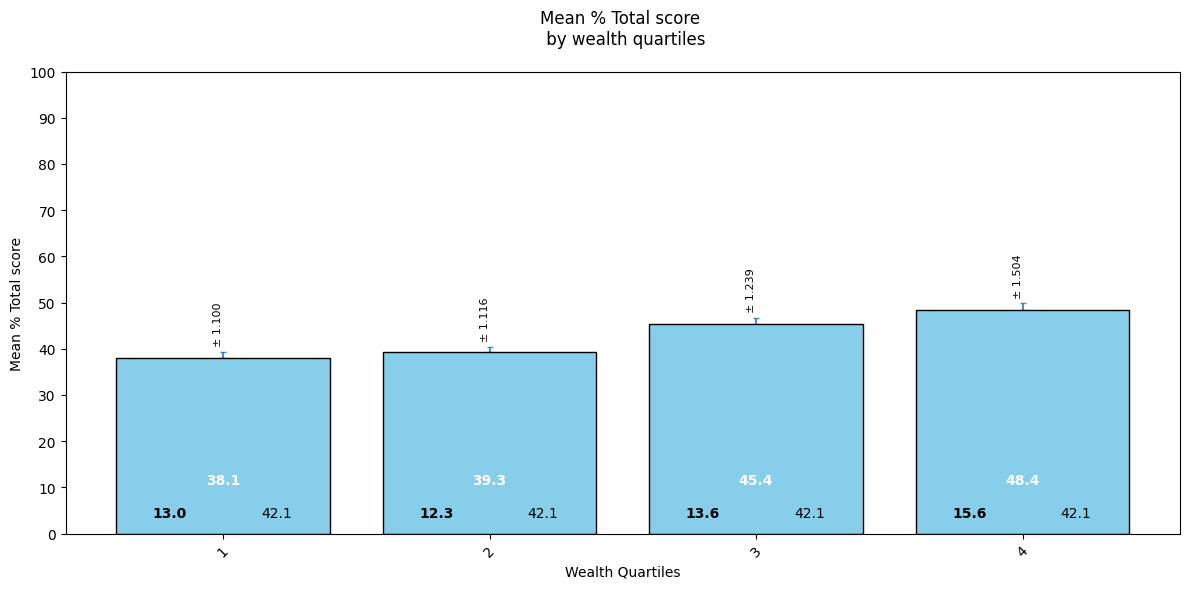

In [44]:
fig, axes = plt.subplots(1, 1, figsize = [12, 6])

sample = wealth_filtered.copy()
wealth_quartiles = sorted(wealth_filtered["wealth_quartile"].unique())

mean_scores = sample.groupby("wealth_quartile")["TotalScore_%"].mean().sort_index()
std_scores =  sample.groupby("wealth_quartile")["TotalScore_%"].std().reindex(mean_scores.index)
sem_scores =  sample.groupby("wealth_quartile")["TotalScore_%"].sem().reindex(mean_scores.index)
med_scores =  sample.groupby("wealth_quartile")["TotalScore_%"].median().reindex(mean_scores.index)

axes.bar(mean_scores.index, mean_scores.values, color="skyblue", edgecolor='black')
axes.errorbar(mean_scores.index, mean_scores.values, yerr = [np.zeros_like(sem_scores), sem_scores],
              fmt = "none", capsize = 2, alpha = 0.8, zorder = 0)

y_max = 100
axes.set_yticks(np.arange(0, 101, step = 10))
axes.set_xticks(np.arange(1, 5, step = 1))

axes.tick_params(axis = "x", rotation = 45)

for j, (mean, std, sem) in enumerate(zip(mean_scores.values, std_scores.values, sem_scores.values)):
    axes.text(j+1, mean + 0.025 * y_max, f"± {sem:.3f}", ha = "right", va = "bottom", fontsize=8, color="black", rotation = 90)
    axes.text(j+1, 0.1 * y_max, f"{mean:.1f}", ha = "center", va = "bottom",
              color='white', fontsize=10, fontweight='bold')
    axes.text(j+1 - 0.2, 0.03 * y_max, f"{std:.1f}", ha = "center", va = "bottom",
              color='black', fontsize=10, fontweight='bold')
    axes.text(j+1 + 0.2, 0.03 * y_max, f"{med:.1f}", ha = "center", va = "bottom",
                     color='black', fontsize=10)
    

axes.set_title(f"Mean % Total score \n by wealth quartiles", pad = 20)
axes.set_ylabel("Mean % Total score")
axes.set_xlabel("Wealth Quartiles")

plt.tight_layout()
plt.show()


---

## Table 2.2 - Per wealth class: Mean Facet Scores

In [45]:
income_classes

array([1, 2, 3, 4, 5, 6])

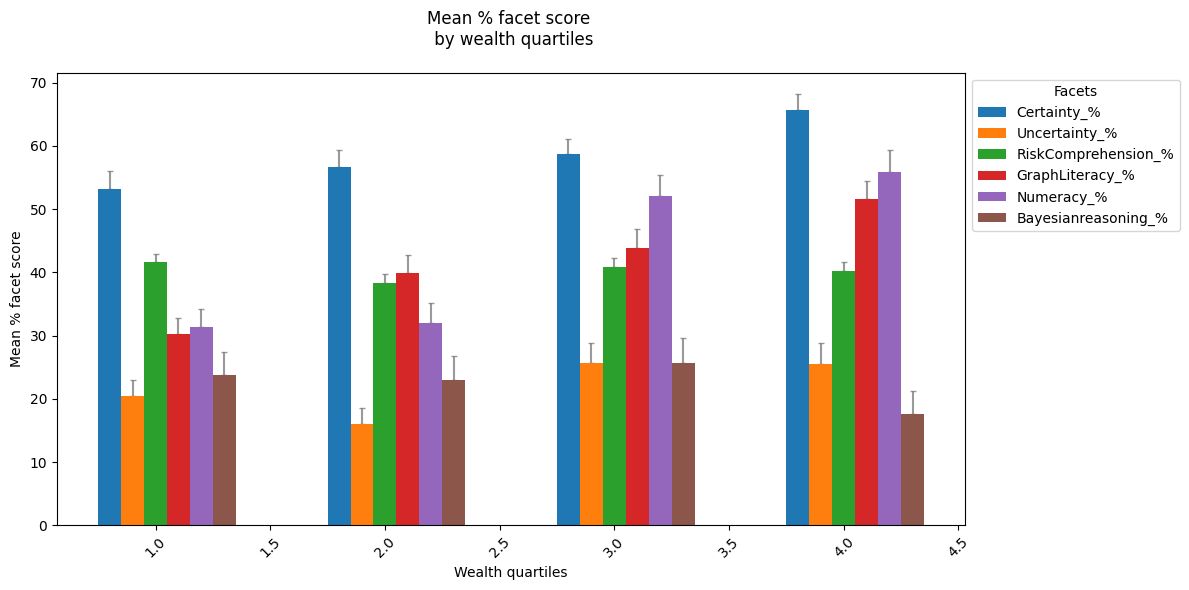

In [46]:
fig, axes = plt.subplots(1, 1, figsize = [12, 6])

sample = wealth_filtered.copy()
wealth_quartiles = np.array(sorted(wealth_filtered["wealth_quartile"].unique()))

mean_scores = sample.groupby("wealth_quartile")[facet_percent_cols].mean().sort_index()
std_scores =  sample.groupby("wealth_quartile")[facet_percent_cols].std().reindex(mean_scores.index)
sem_scores =  sample.groupby("wealth_quartile")[facet_percent_cols].sem().reindex(mean_scores.index)
med_scores =  sample.groupby("wealth_quartile")[facet_percent_cols].median().reindex(mean_scores.index)

y_max = 100
axes.set_yticks(np.arange(0, 101, step = 10))
axes.tick_params(axis = "x", rotation = 45)

width = 0.1

for j, facet in enumerate(facet_percent_cols):
    mean_facet_scores = mean_scores[facet]
    sem_facet_scores = sem_scores[facet]

    offset = (- len(wealth_quartiles)/ 2 + j) * width
    axes.bar(wealth_quartiles + offset , mean_facet_scores, width, label = str(facet))
    axes.errorbar(wealth_quartiles + offset , mean_facet_scores, yerr = [np.zeros_like(sem_facet_scores), sem_facet_scores],
                  fmt = "none", capsize = 2.5, alpha = 0.8, zorder = 0, ecolor = "grey")


axes.set_title(f"Mean % facet score \n by wealth quartiles", pad = 20)
axes.set_ylabel("Mean % facet score")
axes.set_xlabel("Wealth quartiles")
axes.legend(title="Facets", bbox_to_anchor=(1.0, 1))

plt.tight_layout()
plt.show()

---

## Table 5.1: (Countries pooled): Relationship to total sum score and controlling for education and age using income 

In [47]:
wealth_filtered = main.loc[ ~(main["wealth"] == -1)].copy().reset_index()
wealth_quartile = pd.qcut(wealth_filtered["wealth"],q = 4, labels = False, duplicates = "raise") + 1
wealth_filtered["wealth_quartile"] = wealth_quartile.copy()

In [48]:
wealth_filtered = main.loc[ ~(main["wealth"] == -1)].copy().reset_index()
wealth_quartile = pd.qcut(wealth_filtered["wealth"],q = 4, labels = False, duplicates = "raise") + 1
wealth_filtered["wealth_quartile"] = wealth_quartile.copy()

risklit_quartile = pd.qcut(wealth_filtered["TotalScore_19"],q = 4, labels = False ) + 1
wealth_filtered["risklit_quartile"] = risklit_quartile.copy()

data = wealth_filtered.copy()

# Age group 2 = 18 to 35 y/o
# Age group 3 = 36 to 55 y/o
# Age group 4 = 56 to 75 y/o 

age_rec = [0] + sorted(data["age_rec"].unique())
age_dict = {0:"ALL Age", 2:"Only 18-35",
            3:"Only 36-55", 4:"Only 56+"}

In [49]:
# # fig, axes = plt.subplots(3, 1, figsize = [12, 4*6])
# # axes = axes.flatten()

# for i, age_class in enumerate(age_rec):
#     if age_class == 0:
#         sample = data.copy()
#     else:
#         sample = data.loc[ data["age_rec"] == age_class].copy()
#     sample_ready = sample.groupby("risklit_quartile")["wealth_quartile"].value_counts().to_frame().sort_index()
#     sample_ready = sample_ready.unstack(level = "wealth_quartile")
#     sample_ready.columns = sample_ready.columns.droplevel(0)
#     sample_ready.plot(kind='bar', stacked=True)

#     plt.ylabel("count each risk literacy quartile")
#     plt.xlabel("Risk quartile")
#     plt.title(f"Stacked bar chart: {age_dict[age_class]}")
#     plt.legend(title="Wealth quartiles", bbox_to_anchor=(1, 1))
    
# plt.show()

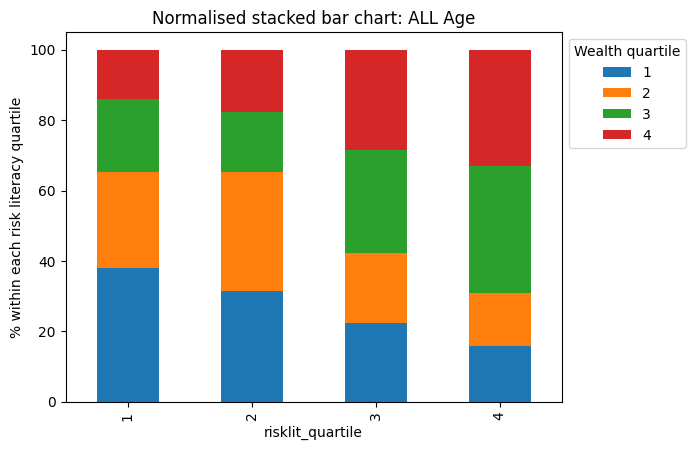

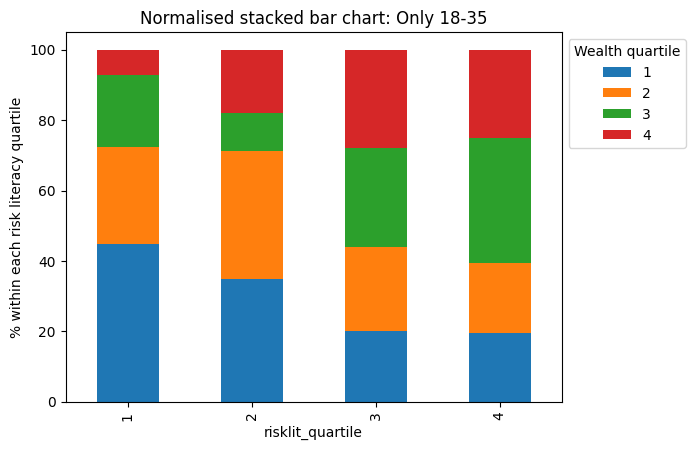

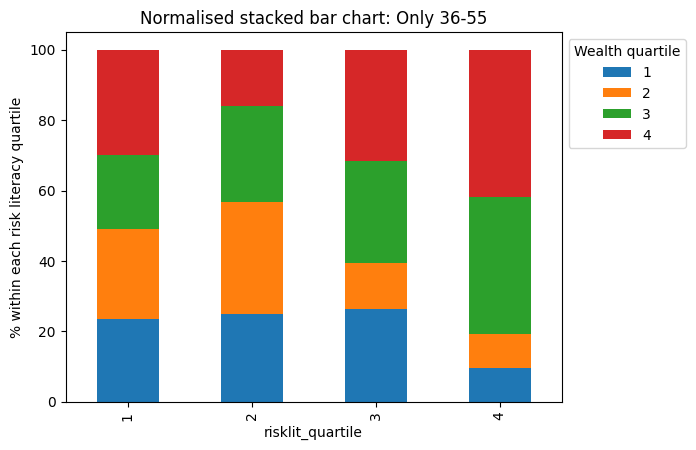

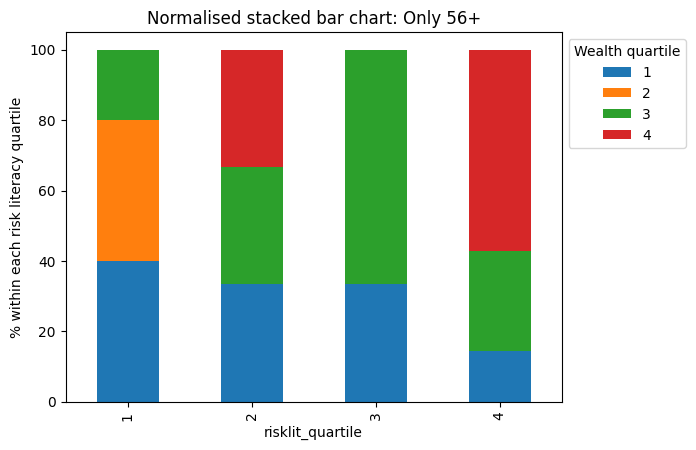

In [50]:
# fig, axes = plt.subplots(3, 1, figsize = [12, 4*6])
# axes = axes.flatten()

for i, age_class in enumerate(age_rec):
    if age_class == 0:
        sample = data.copy()
    else:
        sample = data.loc[ data["age_rec"] == age_class].copy()
    sample_ready = sample.groupby("risklit_quartile")["wealth_quartile"].value_counts().to_frame().sort_index()
    sample_ready = sample_ready.unstack(level = "wealth_quartile")
    sample_ready.columns = sample_ready.columns.droplevel(0)
    sample_ready = sample_ready.div(sample_ready.sum(axis = 1), axis = 0)*100
    sample_ready.plot(kind='bar', stacked=True)

    plt.ylabel("% within each risk literacy quartile")
    plt.title(f"Normalised stacked bar chart: {age_dict[age_class]}")
    plt.legend(title="Wealth quartile", bbox_to_anchor=(1, 1))
    
plt.show()

---

---

---

---

## Ordinal Logistic Regression: Income Class by Risk literacy

### V1: Without any control variables

In [51]:
import statsmodels.api as sm
from statsmodels.miscmodels.ordinal_model import OrderedModel

data = income_filtered.copy()

data["income"] = pd.Categorical(data["income"], ordered=True)

model = OrderedModel(data["income"], data["risklit_quartile"],
                     distr='logit')

res = model.fit(method='bfgs')
print(res.summary())


Optimization terminated successfully.
         Current function value: 1.651295
         Iterations: 16
         Function evaluations: 18
         Gradient evaluations: 18
                             OrderedModel Results                             
Dep. Variable:                 income   Log-Likelihood:                -809.13
Model:                   OrderedModel   AIC:                             1630.
Method:            Maximum Likelihood   BIC:                             1655.
Date:                Sun, 20 Jul 2025                                         
Time:                        06:02:16                                         
No. Observations:                 490                                         
Df Residuals:                     484                                         
Df Model:                           1                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------

### V2: With control of education

In [52]:
import statsmodels.api as sm
from statsmodels.miscmodels.ordinal_model import OrderedModel

data = income_filtered.copy()

data["income"] = pd.Categorical(data["income"], ordered=True)

model = OrderedModel(data["income"], data[["risklit_quartile", "isced"]],
                     distr='logit')

res = model.fit(method='bfgs')
print(res.summary())

Optimization terminated successfully.
         Current function value: 1.601621
         Iterations: 21
         Function evaluations: 23
         Gradient evaluations: 23
                             OrderedModel Results                             
Dep. Variable:                 income   Log-Likelihood:                -784.79
Model:                   OrderedModel   AIC:                             1584.
Method:            Maximum Likelihood   BIC:                             1613.
Date:                Sun, 20 Jul 2025                                         
Time:                        06:02:16                                         
No. Observations:                 490                                         
Df Residuals:                     483                                         
Df Model:                           2                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------

### V3: With control of education and age

In [53]:
import statsmodels.api as sm
from statsmodels.miscmodels.ordinal_model import OrderedModel

data = income_filtered.copy()

data["income"] = pd.Categorical(data["income"], ordered=True)

model = OrderedModel(data["income"], data[["risklit_quartile", "isced", "age_rec"]],
                     distr='logit')

# Age group 2 = 18 to 35 y/o
# Age group 3 = 36 to 55 y/o
# Age group 4 = 56 to 75 y/o 

res = model.fit(method='bfgs')
print(res.summary())

Optimization terminated successfully.
         Current function value: 1.600542
         Iterations: 28
         Function evaluations: 29
         Gradient evaluations: 29
                             OrderedModel Results                             
Dep. Variable:                 income   Log-Likelihood:                -784.27
Model:                   OrderedModel   AIC:                             1585.
Method:            Maximum Likelihood   BIC:                             1618.
Date:                Sun, 20 Jul 2025                                         
Time:                        06:02:16                                         
No. Observations:                 490                                         
Df Residuals:                     482                                         
Df Model:                           3                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------

### V4: With control of education and age and financial literacy

In [54]:
import statsmodels.api as sm
from statsmodels.miscmodels.ordinal_model import OrderedModel

data = income_filtered.copy()

data["income"] = pd.Categorical(data["income"], ordered=True)

model = OrderedModel(data["income"], data[["risklit_quartile", "isced", "age_rec", "FinancialLiteracy_%"]],
                     distr='logit')

# Age group 2 = 18 to 35 y/o
# Age group 3 = 36 to 55 y/o
# Age group 4 = 56 to 75 y/o 

res = model.fit(method='bfgs')
print(res.summary())

Optimization terminated successfully.
         Current function value: 1.596777
         Iterations: 31
         Function evaluations: 37
         Gradient evaluations: 37
                             OrderedModel Results                             
Dep. Variable:                 income   Log-Likelihood:                -782.42
Model:                   OrderedModel   AIC:                             1583.
Method:            Maximum Likelihood   BIC:                             1621.
Date:                Sun, 20 Jul 2025                                         
Time:                        06:02:16                                         
No. Observations:                 490                                         
Df Residuals:                     481                                         
Df Model:                           4                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------

### V5: With control of education, age , financial literacy, CRT

In [55]:
import statsmodels.api as sm
from statsmodels.miscmodels.ordinal_model import OrderedModel

data = income_filtered.copy()

data["income"] = pd.Categorical(data["income"], ordered=True)

model = OrderedModel(data["income"], data[["risklit_quartile", "isced", "age_rec", "FinancialLiteracy_%", "CRTScore_%"]],
                     distr='logit')

# Age group 2 = 18 to 35 y/o
# Age group 3 = 36 to 55 y/o
# Age group 4 = 56 to 75 y/o 

res = model.fit(method='bfgs')
print(res.summary())

Optimization terminated successfully.
         Current function value: 1.582208
         Iterations: 31
         Function evaluations: 34
         Gradient evaluations: 34
                             OrderedModel Results                             
Dep. Variable:                 income   Log-Likelihood:                -775.28
Model:                   OrderedModel   AIC:                             1571.
Method:            Maximum Likelihood   BIC:                             1613.
Date:                Sun, 20 Jul 2025                                         
Time:                        06:02:16                                         
No. Observations:                 490                                         
Df Residuals:                     480                                         
Df Model:                           5                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------

---

## Ordinal Logistic Regression: Income Class by Risk literacy FOR 36-55 years old

### V1: without control of education

In [56]:
data = income_filtered.loc[income_filtered["age_rec"] == 3].copy()

data["income"] = pd.Categorical(data["income"], ordered=True)

model = OrderedModel(data["income"], data["risklit_quartile"],
                     distr='logit')

res = model.fit(method='bfgs')
print(res.summary())

Optimization terminated successfully.
         Current function value: 1.673578
         Iterations: 15
         Function evaluations: 17
         Gradient evaluations: 17
                             OrderedModel Results                             
Dep. Variable:                 income   Log-Likelihood:                -267.77
Model:                   OrderedModel   AIC:                             547.5
Method:            Maximum Likelihood   BIC:                             566.0
Date:                Sun, 20 Jul 2025                                         
Time:                        06:02:16                                         
No. Observations:                 160                                         
Df Residuals:                     154                                         
Df Model:                           1                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------

### V2: with control of education

In [57]:
data = income_filtered.loc[income_filtered["age_rec"] == 3].copy()

data["income"] = pd.Categorical(data["income"], ordered=True)

model = OrderedModel(data["income"], data[["risklit_quartile", "isced"]],
                     distr='logit')

res = model.fit(method='bfgs')
print(res.summary())

Optimization terminated successfully.
         Current function value: 1.666403
         Iterations: 23
         Function evaluations: 25
         Gradient evaluations: 25
                             OrderedModel Results                             
Dep. Variable:                 income   Log-Likelihood:                -266.62
Model:                   OrderedModel   AIC:                             547.2
Method:            Maximum Likelihood   BIC:                             568.8
Date:                Sun, 20 Jul 2025                                         
Time:                        06:02:16                                         
No. Observations:                 160                                         
Df Residuals:                     153                                         
Df Model:                           2                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------

### V3: with control of education and financial literacy

In [58]:
data = income_filtered.loc[income_filtered["age_rec"] == 3].copy()

data["income"] = pd.Categorical(data["income"], ordered=True)

model = OrderedModel(data["income"], data[["risklit_quartile", "isced", "FinancialLiteracy_%"]],
                     distr='logit')

res = model.fit(method='bfgs')
print(res.summary())

Optimization terminated successfully.
         Current function value: 1.632244
         Iterations: 28
         Function evaluations: 31
         Gradient evaluations: 31
                             OrderedModel Results                             
Dep. Variable:                 income   Log-Likelihood:                -261.16
Model:                   OrderedModel   AIC:                             538.3
Method:            Maximum Likelihood   BIC:                             562.9
Date:                Sun, 20 Jul 2025                                         
Time:                        06:02:16                                         
No. Observations:                 160                                         
Df Residuals:                     152                                         
Df Model:                           3                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------

### V4: with control of education, financial literacy, CRT

In [59]:
data = income_filtered.loc[income_filtered["age_rec"] == 3].copy()

data["income"] = pd.Categorical(data["income"], ordered=True)

model = OrderedModel(data["income"], data[["risklit_quartile", "isced", "FinancialLiteracy_%", "CRTScore_%"]],
                     distr='logit')

res = model.fit(method='bfgs')
print(res.summary())

Optimization terminated successfully.
         Current function value: 1.612295
         Iterations: 28
         Function evaluations: 32
         Gradient evaluations: 32
                             OrderedModel Results                             
Dep. Variable:                 income   Log-Likelihood:                -257.97
Model:                   OrderedModel   AIC:                             533.9
Method:            Maximum Likelihood   BIC:                             561.6
Date:                Sun, 20 Jul 2025                                         
Time:                        06:02:16                                         
No. Observations:                 160                                         
Df Residuals:                     151                                         
Df Model:                           4                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------

---

---

## Ordinal Logistic Regression: Income Terciles by Risk literacy

### V1: Without any control variables

In [60]:
import statsmodels.api as sm
from statsmodels.miscmodels.ordinal_model import OrderedModel

data = income_filtered.copy()

data["income_tercile"] = pd.Categorical(data["income_tercile"], ordered=True)

model = OrderedModel(data["income_tercile"], data["risklit_quartile"],
                     distr='logit')

res = model.fit(method='bfgs')
print(res.summary())


Optimization terminated successfully.
         Current function value: 1.025577
         Iterations: 10
         Function evaluations: 12
         Gradient evaluations: 12
                             OrderedModel Results                             
Dep. Variable:         income_tercile   Log-Likelihood:                -502.53
Model:                   OrderedModel   AIC:                             1011.
Method:            Maximum Likelihood   BIC:                             1024.
Date:                Sun, 20 Jul 2025                                         
Time:                        06:02:16                                         
No. Observations:                 490                                         
Df Residuals:                     487                                         
Df Model:                           1                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------

### V2: With control of education

In [61]:
import statsmodels.api as sm
from statsmodels.miscmodels.ordinal_model import OrderedModel

data = income_filtered.copy()

data["income_tercile"] = pd.Categorical(data["income_tercile"], ordered=True)

model = OrderedModel(data["income_tercile"], data[["risklit_quartile", "isced"]],
                     distr='logit')

res = model.fit(method='bfgs')
print(res.summary())

Optimization terminated successfully.
         Current function value: 0.986995
         Iterations: 14
         Function evaluations: 15
         Gradient evaluations: 15
                             OrderedModel Results                             
Dep. Variable:         income_tercile   Log-Likelihood:                -483.63
Model:                   OrderedModel   AIC:                             975.3
Method:            Maximum Likelihood   BIC:                             992.0
Date:                Sun, 20 Jul 2025                                         
Time:                        06:02:16                                         
No. Observations:                 490                                         
Df Residuals:                     486                                         
Df Model:                           2                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------

### V3: With control of education and age

In [62]:
import statsmodels.api as sm
from statsmodels.miscmodels.ordinal_model import OrderedModel

data = income_filtered.copy()

data["income_tercile"] = pd.Categorical(data["income_tercile"], ordered=True)

model = OrderedModel(data["income_tercile"], data[["risklit_quartile", "isced", "age_rec"]],
                     distr='logit')

# Age group 2 = 18 to 35 y/o
# Age group 3 = 36 to 55 y/o
# Age group 4 = 56 to 75 y/o 

res = model.fit(method='bfgs')
print(res.summary())

Optimization terminated successfully.
         Current function value: 0.986291
         Iterations: 19
         Function evaluations: 20
         Gradient evaluations: 20
                             OrderedModel Results                             
Dep. Variable:         income_tercile   Log-Likelihood:                -483.28
Model:                   OrderedModel   AIC:                             976.6
Method:            Maximum Likelihood   BIC:                             997.5
Date:                Sun, 20 Jul 2025                                         
Time:                        06:02:16                                         
No. Observations:                 490                                         
Df Residuals:                     485                                         
Df Model:                           3                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------

### V4: With control of education and age and financial literacy

In [63]:
import statsmodels.api as sm
from statsmodels.miscmodels.ordinal_model import OrderedModel

data = income_filtered.copy()

data["income_tercile"] = pd.Categorical(data["income_tercile"], ordered=True)

model = OrderedModel(data["income_tercile"], data[["risklit_quartile", "isced", "age_rec", "FinancialLiteracy_%"]],
                     distr='logit')

# Age group 2 = 18 to 35 y/o
# Age group 3 = 36 to 55 y/o
# Age group 4 = 56 to 75 y/o 

res = model.fit(method='bfgs')
print(res.summary())

Optimization terminated successfully.
         Current function value: 0.984773
         Iterations: 21
         Function evaluations: 26
         Gradient evaluations: 26
                             OrderedModel Results                             
Dep. Variable:         income_tercile   Log-Likelihood:                -482.54
Model:                   OrderedModel   AIC:                             977.1
Method:            Maximum Likelihood   BIC:                             1002.
Date:                Sun, 20 Jul 2025                                         
Time:                        06:02:17                                         
No. Observations:                 490                                         
Df Residuals:                     484                                         
Df Model:                           4                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------

### V5: With control of education, age, financial literacy, CRT

In [64]:
import statsmodels.api as sm
from statsmodels.miscmodels.ordinal_model import OrderedModel

data = income_filtered.copy()

data["income_tercile"] = pd.Categorical(data["income_tercile"], ordered=True)

model = OrderedModel(data["income_tercile"], data[["risklit_quartile", "isced", "age_rec", "FinancialLiteracy_%", "CRTScore_%"]],
                     distr='logit')

# Age group 2 = 18 to 35 y/o
# Age group 3 = 36 to 55 y/o
# Age group 4 = 56 to 75 y/o 

res = model.fit(method='bfgs')
print(res.summary())

Optimization terminated successfully.
         Current function value: 0.973532
         Iterations: 22
         Function evaluations: 25
         Gradient evaluations: 25
                             OrderedModel Results                             
Dep. Variable:         income_tercile   Log-Likelihood:                -477.03
Model:                   OrderedModel   AIC:                             968.1
Method:            Maximum Likelihood   BIC:                             997.4
Date:                Sun, 20 Jul 2025                                         
Time:                        06:02:17                                         
No. Observations:                 490                                         
Df Residuals:                     483                                         
Df Model:                           5                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------

---

## Ordinal Logistic Regression: Income Tercile by Risk literacy FOR 36-55 years old

### V1: without control of education

In [65]:
data = income_filtered.loc[income_filtered["age_rec"] == 3].copy()

data["income_tercile"] = pd.Categorical(data["income_tercile"], ordered=True)

model = OrderedModel(data["income_tercile"], data["risklit_quartile"],
                     distr='logit')

res = model.fit(method='bfgs')
print(res.summary())

Optimization terminated successfully.
         Current function value: 0.980044
         Iterations: 10
         Function evaluations: 11
         Gradient evaluations: 11
                             OrderedModel Results                             
Dep. Variable:         income_tercile   Log-Likelihood:                -156.81
Model:                   OrderedModel   AIC:                             319.6
Method:            Maximum Likelihood   BIC:                             328.8
Date:                Sun, 20 Jul 2025                                         
Time:                        06:02:17                                         
No. Observations:                 160                                         
Df Residuals:                     157                                         
Df Model:                           1                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------

### V2: with control of education

In [66]:
data = income_filtered.loc[income_filtered["age_rec"] == 3].copy()

data["income_tercile"] = pd.Categorical(data["income_tercile"], ordered=True)

model = OrderedModel(data["income_tercile"], data[["risklit_quartile", "isced"]],
                     distr='logit')

res = model.fit(method='bfgs')
print(res.summary())

Optimization terminated successfully.
         Current function value: 0.973518
         Iterations: 14
         Function evaluations: 15
         Gradient evaluations: 15
                             OrderedModel Results                             
Dep. Variable:         income_tercile   Log-Likelihood:                -155.76
Model:                   OrderedModel   AIC:                             319.5
Method:            Maximum Likelihood   BIC:                             331.8
Date:                Sun, 20 Jul 2025                                         
Time:                        06:02:17                                         
No. Observations:                 160                                         
Df Residuals:                     156                                         
Df Model:                           2                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------

### V3: with control of education and financial literacy

In [67]:
data = income_filtered.loc[income_filtered["age_rec"] == 3].copy()

data["income_tercile"] = pd.Categorical(data["income_tercile"], ordered=True)

model = OrderedModel(data["income_tercile"], data[["risklit_quartile", "isced", "FinancialLiteracy_%"]],
                     distr='logit')

res = model.fit(method='bfgs')
print(res.summary())

Optimization terminated successfully.
         Current function value: 0.950300
         Iterations: 17
         Function evaluations: 20
         Gradient evaluations: 20
                             OrderedModel Results                             
Dep. Variable:         income_tercile   Log-Likelihood:                -152.05
Model:                   OrderedModel   AIC:                             314.1
Method:            Maximum Likelihood   BIC:                             329.5
Date:                Sun, 20 Jul 2025                                         
Time:                        06:02:17                                         
No. Observations:                 160                                         
Df Residuals:                     155                                         
Df Model:                           3                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------

### V4: with control of education,  financial literacy, CRT

In [68]:
data = income_filtered.loc[income_filtered["age_rec"] == 3].copy()

data["income_tercile"] = pd.Categorical(data["income_tercile"], ordered=True)

model = OrderedModel(data["income_tercile"], data[["risklit_quartile", "isced", "FinancialLiteracy_%", "CRTScore_%"]],
                     distr='logit')

res = model.fit(method='bfgs')
print(res.summary())

Optimization terminated successfully.
         Current function value: 0.936579
         Iterations: 20
         Function evaluations: 23
         Gradient evaluations: 23
                             OrderedModel Results                             
Dep. Variable:         income_tercile   Log-Likelihood:                -149.85
Model:                   OrderedModel   AIC:                             311.7
Method:            Maximum Likelihood   BIC:                             330.2
Date:                Sun, 20 Jul 2025                                         
Time:                        06:02:17                                         
No. Observations:                 160                                         
Df Residuals:                     154                                         
Df Model:                           4                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------

---

---

## Ordinal Logistic Regression: Income Quartiles by Risk literacy

### V1: Without any control variables

In [69]:
import statsmodels.api as sm
from statsmodels.miscmodels.ordinal_model import OrderedModel

data = income_filtered.copy()

data["income_quartile"] = pd.Categorical(data["income_quartile"], ordered=True)

model = OrderedModel(data["income_quartile"], data["risklit_quartile"],
                     distr='logit')

res = model.fit(method='bfgs')
print(res.summary())


Optimization terminated successfully.
         Current function value: 1.336127
         Iterations: 12
         Function evaluations: 14
         Gradient evaluations: 14
                             OrderedModel Results                             
Dep. Variable:        income_quartile   Log-Likelihood:                -654.70
Model:                   OrderedModel   AIC:                             1317.
Method:            Maximum Likelihood   BIC:                             1334.
Date:                Sun, 20 Jul 2025                                         
Time:                        06:02:17                                         
No. Observations:                 490                                         
Df Residuals:                     486                                         
Df Model:                           1                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------

### V2: With control of education

In [70]:
import statsmodels.api as sm
from statsmodels.miscmodels.ordinal_model import OrderedModel

data = income_filtered.copy()

data["income_quartile"] = pd.Categorical(data["income_quartile"], ordered=True)

model = OrderedModel(data["income_quartile"], data[["risklit_quartile", "isced"]],
                     distr='logit')

res = model.fit(method='bfgs')
print(res.summary())

Optimization terminated successfully.
         Current function value: 1.285584
         Iterations: 16
         Function evaluations: 17
         Gradient evaluations: 17
                             OrderedModel Results                             
Dep. Variable:        income_quartile   Log-Likelihood:                -629.94
Model:                   OrderedModel   AIC:                             1270.
Method:            Maximum Likelihood   BIC:                             1291.
Date:                Sun, 20 Jul 2025                                         
Time:                        06:02:17                                         
No. Observations:                 490                                         
Df Residuals:                     485                                         
Df Model:                           2                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------

### V3: With control of education and age

In [71]:
import statsmodels.api as sm
from statsmodels.miscmodels.ordinal_model import OrderedModel

data = income_filtered.copy()

data["income_quartile"] = pd.Categorical(data["income_quartile"], ordered=True)

model = OrderedModel(data["income_quartile"], data[["risklit_quartile", "isced", "age_rec"]],
                     distr='logit')

# Age group 2 = 18 to 35 y/o
# Age group 3 = 36 to 55 y/o
# Age group 4 = 56 to 75 y/o 

res = model.fit(method='bfgs')
print(res.summary())

Optimization terminated successfully.
         Current function value: 1.284529
         Iterations: 20
         Function evaluations: 21
         Gradient evaluations: 21
                             OrderedModel Results                             
Dep. Variable:        income_quartile   Log-Likelihood:                -629.42
Model:                   OrderedModel   AIC:                             1271.
Method:            Maximum Likelihood   BIC:                             1296.
Date:                Sun, 20 Jul 2025                                         
Time:                        06:02:17                                         
No. Observations:                 490                                         
Df Residuals:                     484                                         
Df Model:                           3                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------

### V4: With control of education and age and financial literacy

In [72]:
import statsmodels.api as sm
from statsmodels.miscmodels.ordinal_model import OrderedModel

data = income_filtered.copy()

data["income_quartile"] = pd.Categorical(data["income_quartile"], ordered=True)

model = OrderedModel(data["income_quartile"], data[["risklit_quartile", "isced", "age_rec", "FinancialLiteracy_%"]],
                     distr='logit')

# Age group 2 = 18 to 35 y/o
# Age group 3 = 36 to 55 y/o
# Age group 4 = 56 to 75 y/o 

res = model.fit(method='bfgs')
print(res.summary())

Optimization terminated successfully.
         Current function value: 1.280385
         Iterations: 20
         Function evaluations: 26
         Gradient evaluations: 26
                             OrderedModel Results                             
Dep. Variable:        income_quartile   Log-Likelihood:                -627.39
Model:                   OrderedModel   AIC:                             1269.
Method:            Maximum Likelihood   BIC:                             1298.
Date:                Sun, 20 Jul 2025                                         
Time:                        06:02:17                                         
No. Observations:                 490                                         
Df Residuals:                     483                                         
Df Model:                           4                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------

### V5: With control of education, age, financial literacy, CRT

In [73]:
import statsmodels.api as sm
from statsmodels.miscmodels.ordinal_model import OrderedModel

data = income_filtered.copy()

data["income_quartile"] = pd.Categorical(data["income_quartile"], ordered=True)

model = OrderedModel(data["income_quartile"], data[["risklit_quartile", "isced", "age_rec", "FinancialLiteracy_%", "CRTScore_%"]],
                     distr='logit')

# Age group 2 = 18 to 35 y/o
# Age group 3 = 36 to 55 y/o
# Age group 4 = 56 to 75 y/o 

res = model.fit(method='bfgs')
print(res.summary())

Optimization terminated successfully.
         Current function value: 1.266301
         Iterations: 24
         Function evaluations: 27
         Gradient evaluations: 27
                             OrderedModel Results                             
Dep. Variable:        income_quartile   Log-Likelihood:                -620.49
Model:                   OrderedModel   AIC:                             1257.
Method:            Maximum Likelihood   BIC:                             1291.
Date:                Sun, 20 Jul 2025                                         
Time:                        06:02:17                                         
No. Observations:                 490                                         
Df Residuals:                     482                                         
Df Model:                           5                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------

---

## Ordinal Logistic Regression: Income Quartile by Risk literacy FOR 36-55 years old

### V1: without control of education

In [74]:
data = income_filtered.loc[income_filtered["age_rec"] == 3].copy()

data["income_quartile"] = pd.Categorical(data["income_quartile"], ordered=True)

model = OrderedModel(data["income_quartile"], data["risklit_quartile"],
                     distr='logit')

res = model.fit(method='bfgs')
print(res.summary())

Optimization terminated successfully.
         Current function value: 1.311742
         Iterations: 12
         Function evaluations: 14
         Gradient evaluations: 14
                             OrderedModel Results                             
Dep. Variable:        income_quartile   Log-Likelihood:                -209.88
Model:                   OrderedModel   AIC:                             427.8
Method:            Maximum Likelihood   BIC:                             440.1
Date:                Sun, 20 Jul 2025                                         
Time:                        06:02:17                                         
No. Observations:                 160                                         
Df Residuals:                     156                                         
Df Model:                           1                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------

### V2: with control of education

In [75]:
data = income_filtered.loc[income_filtered["age_rec"] == 3].copy()

data["income_quartile"] = pd.Categorical(data["income_quartile"], ordered=True)

model = OrderedModel(data["income_quartile"], data[["risklit_quartile", "isced"]],
                     distr='logit')

res = model.fit(method='bfgs')
print(res.summary())

Optimization terminated successfully.
         Current function value: 1.305766
         Iterations: 15
         Function evaluations: 16
         Gradient evaluations: 16
                             OrderedModel Results                             
Dep. Variable:        income_quartile   Log-Likelihood:                -208.92
Model:                   OrderedModel   AIC:                             427.8
Method:            Maximum Likelihood   BIC:                             443.2
Date:                Sun, 20 Jul 2025                                         
Time:                        06:02:17                                         
No. Observations:                 160                                         
Df Residuals:                     155                                         
Df Model:                           2                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------

### V3: with control of education and financial literacy

In [76]:
data = income_filtered.loc[income_filtered["age_rec"] == 3].copy()

data["income_quartile"] = pd.Categorical(data["income_quartile"], ordered=True)

model = OrderedModel(data["income_quartile"], data[["risklit_quartile", "isced", "FinancialLiteracy_%"]],
                     distr='logit')

res = model.fit(method='bfgs')
print(res.summary())

Optimization terminated successfully.
         Current function value: 1.272119
         Iterations: 20
         Function evaluations: 23
         Gradient evaluations: 23
                             OrderedModel Results                             
Dep. Variable:        income_quartile   Log-Likelihood:                -203.54
Model:                   OrderedModel   AIC:                             419.1
Method:            Maximum Likelihood   BIC:                             437.5
Date:                Sun, 20 Jul 2025                                         
Time:                        06:02:17                                         
No. Observations:                 160                                         
Df Residuals:                     154                                         
Df Model:                           3                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------

### V4: with control of education, financial literacy, CRT

In [77]:
data = income_filtered.loc[income_filtered["age_rec"] == 3].copy()

data["income_quartile"] = pd.Categorical(data["income_quartile"], ordered=True)

model = OrderedModel(data["income_quartile"], data[["risklit_quartile", "isced", "FinancialLiteracy_%", "CRTScore_%"]],
                     distr='logit')

res = model.fit(method='bfgs')
print(res.summary())

Optimization terminated successfully.
         Current function value: 1.250637
         Iterations: 20
         Function evaluations: 24
         Gradient evaluations: 24
                             OrderedModel Results                             
Dep. Variable:        income_quartile   Log-Likelihood:                -200.10
Model:                   OrderedModel   AIC:                             414.2
Method:            Maximum Likelihood   BIC:                             435.7
Date:                Sun, 20 Jul 2025                                         
Time:                        06:02:18                                         
No. Observations:                 160                                         
Df Residuals:                     153                                         
Df Model:                           4                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------

---

---

## Ordinal Logistic Regression: Wealth Quartiles by Risk literacy

### V1: Without any control variables

In [78]:
import statsmodels.api as sm
from statsmodels.miscmodels.ordinal_model import OrderedModel

data = wealth_filtered.copy()

data["wealth_quartile"] = pd.Categorical(data["wealth_quartile"], ordered=True)

model = OrderedModel(data["wealth_quartile"], data["risklit_quartile"],
                     distr='logit')

res = model.fit(method='bfgs')
print(res.summary())


Optimization terminated successfully.
         Current function value: 1.347303
         Iterations: 13
         Function evaluations: 15
         Gradient evaluations: 15
                             OrderedModel Results                             
Dep. Variable:        wealth_quartile   Log-Likelihood:                -660.18
Model:                   OrderedModel   AIC:                             1328.
Method:            Maximum Likelihood   BIC:                             1345.
Date:                Sun, 20 Jul 2025                                         
Time:                        06:02:18                                         
No. Observations:                 490                                         
Df Residuals:                     486                                         
Df Model:                           1                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------

### V2: With control of education

In [79]:
import statsmodels.api as sm
from statsmodels.miscmodels.ordinal_model import OrderedModel

data = wealth_filtered.copy()

data["wealth_quartile"] = pd.Categorical(data["wealth_quartile"], ordered=True)

model = OrderedModel(data["wealth_quartile"], data[["risklit_quartile", "isced"]],
                     distr='logit')

res = model.fit(method='bfgs')
print(res.summary())

Optimization terminated successfully.
         Current function value: 1.315475
         Iterations: 16
         Function evaluations: 17
         Gradient evaluations: 17
                             OrderedModel Results                             
Dep. Variable:        wealth_quartile   Log-Likelihood:                -644.58
Model:                   OrderedModel   AIC:                             1299.
Method:            Maximum Likelihood   BIC:                             1320.
Date:                Sun, 20 Jul 2025                                         
Time:                        06:02:18                                         
No. Observations:                 490                                         
Df Residuals:                     485                                         
Df Model:                           2                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------

### V3: With control of education and age

In [80]:
import statsmodels.api as sm
from statsmodels.miscmodels.ordinal_model import OrderedModel

data = wealth_filtered.copy()

data["wealth_quartile"] = pd.Categorical(data["wealth_quartile"], ordered=True)

model = OrderedModel(data["wealth_quartile"], data[["risklit_quartile", "isced", "age_rec"]],
                     distr='logit')

# Age group 2 = 18 to 35 y/o
# Age group 3 = 36 to 55 y/o
# Age group 4 = 56 to 75 y/o 

res = model.fit(method='bfgs')
print(res.summary())

Optimization terminated successfully.
         Current function value: 1.305178
         Iterations: 21
         Function evaluations: 22
         Gradient evaluations: 22
                             OrderedModel Results                             
Dep. Variable:        wealth_quartile   Log-Likelihood:                -639.54
Model:                   OrderedModel   AIC:                             1291.
Method:            Maximum Likelihood   BIC:                             1316.
Date:                Sun, 20 Jul 2025                                         
Time:                        06:02:18                                         
No. Observations:                 490                                         
Df Residuals:                     484                                         
Df Model:                           3                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------

### V4: With control of education, age and Financial Lit

In [81]:
import statsmodels.api as sm
from statsmodels.miscmodels.ordinal_model import OrderedModel

data = wealth_filtered.copy()

data["wealth_quartile"] = pd.Categorical(data["wealth_quartile"], ordered=True)

model = OrderedModel(data["wealth_quartile"], data[["risklit_quartile", "isced", "age_rec", "FinancialLiteracy_%"]],
                     distr='logit')

# Age group 2 = 18 to 35 y/o
# Age group 3 = 36 to 55 y/o
# Age group 4 = 56 to 75 y/o 

res = model.fit(method='bfgs')
print(res.summary())

Optimization terminated successfully.
         Current function value: 1.292755
         Iterations: 24
         Function evaluations: 27
         Gradient evaluations: 27
                             OrderedModel Results                             
Dep. Variable:        wealth_quartile   Log-Likelihood:                -633.45
Model:                   OrderedModel   AIC:                             1281.
Method:            Maximum Likelihood   BIC:                             1310.
Date:                Sun, 20 Jul 2025                                         
Time:                        06:02:18                                         
No. Observations:                 490                                         
Df Residuals:                     483                                         
Df Model:                           4                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------

### V5: With control of education, age, Financial Lit, CRT

In [82]:
import statsmodels.api as sm
from statsmodels.miscmodels.ordinal_model import OrderedModel

data = wealth_filtered.copy()

data["wealth_quartile"] = pd.Categorical(data["wealth_quartile"], ordered=True)

model = OrderedModel(data["wealth_quartile"], data[["risklit_quartile", "isced", "age_rec", "FinancialLiteracy_%", "CRTScore_%"]],
                     distr='logit')

# Age group 2 = 18 to 35 y/o
# Age group 3 = 36 to 55 y/o
# Age group 4 = 56 to 75 y/o 

res = model.fit(method='bfgs')
print(res.summary())

Optimization terminated successfully.
         Current function value: 1.289613
         Iterations: 25
         Function evaluations: 30
         Gradient evaluations: 30
                             OrderedModel Results                             
Dep. Variable:        wealth_quartile   Log-Likelihood:                -631.91
Model:                   OrderedModel   AIC:                             1280.
Method:            Maximum Likelihood   BIC:                             1313.
Date:                Sun, 20 Jul 2025                                         
Time:                        06:02:18                                         
No. Observations:                 490                                         
Df Residuals:                     482                                         
Df Model:                           5                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------

---

## Ordinal Logistic Regression: Wealth Quartiles by Risk literacy FOR 36-55 years old

### V1: without control of education

In [83]:
data = wealth_filtered.loc[wealth_filtered["age_rec"] == 3].copy()

data["wealth_quartile"] = pd.Categorical(data["wealth_quartile"], ordered=True)

model = OrderedModel(data["wealth_quartile"], data["risklit_quartile"],
                     distr='logit')

res = model.fit(method='bfgs')
print(res.summary())

Optimization terminated successfully.
         Current function value: 1.361074
         Iterations: 13
         Function evaluations: 15
         Gradient evaluations: 15
                             OrderedModel Results                             
Dep. Variable:        wealth_quartile   Log-Likelihood:                -217.77
Model:                   OrderedModel   AIC:                             443.5
Method:            Maximum Likelihood   BIC:                             455.8
Date:                Sun, 20 Jul 2025                                         
Time:                        06:02:18                                         
No. Observations:                 160                                         
Df Residuals:                     156                                         
Df Model:                           1                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------

### V2: with control of education

In [84]:
data = wealth_filtered.loc[wealth_filtered["age_rec"] == 3].copy()

data["wealth_quartile"] = pd.Categorical(data["wealth_quartile"], ordered=True)

model = OrderedModel(data["wealth_quartile"], data[["risklit_quartile", "isced"]],
                     distr='logit')

res = model.fit(method='bfgs')
print(res.summary())

Optimization terminated successfully.
         Current function value: 1.331243
         Iterations: 18
         Function evaluations: 19
         Gradient evaluations: 19
                             OrderedModel Results                             
Dep. Variable:        wealth_quartile   Log-Likelihood:                -213.00
Model:                   OrderedModel   AIC:                             436.0
Method:            Maximum Likelihood   BIC:                             451.4
Date:                Sun, 20 Jul 2025                                         
Time:                        06:02:18                                         
No. Observations:                 160                                         
Df Residuals:                     155                                         
Df Model:                           2                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------

### V3: with control of education and financial literacy

In [85]:
data = wealth_filtered.loc[wealth_filtered["age_rec"] == 3].copy()

data["wealth_quartile"] = pd.Categorical(data["wealth_quartile"], ordered=True)

model = OrderedModel(data["wealth_quartile"], data[["risklit_quartile", "isced", "FinancialLiteracy_%"]],
                     distr='logit')

res = model.fit(method='bfgs')
print(res.summary())

Optimization terminated successfully.
         Current function value: 1.320758
         Iterations: 21
         Function evaluations: 24
         Gradient evaluations: 24
                             OrderedModel Results                             
Dep. Variable:        wealth_quartile   Log-Likelihood:                -211.32
Model:                   OrderedModel   AIC:                             434.6
Method:            Maximum Likelihood   BIC:                             453.1
Date:                Sun, 20 Jul 2025                                         
Time:                        06:02:18                                         
No. Observations:                 160                                         
Df Residuals:                     154                                         
Df Model:                           3                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------

### V4: with control of education, financial literacy, CRT

In [86]:
data = wealth_filtered.loc[wealth_filtered["age_rec"] == 3].copy()

data["wealth_quartile"] = pd.Categorical(data["wealth_quartile"], ordered=True)

model = OrderedModel(data["wealth_quartile"], data[["risklit_quartile", "isced", "FinancialLiteracy_%", "CRTScore_%"]],
                     distr='logit')

res = model.fit(method='bfgs')
print(res.summary())

Optimization terminated successfully.
         Current function value: 1.320484
         Iterations: 21
         Function evaluations: 26
         Gradient evaluations: 26
                             OrderedModel Results                             
Dep. Variable:        wealth_quartile   Log-Likelihood:                -211.28
Model:                   OrderedModel   AIC:                             436.6
Method:            Maximum Likelihood   BIC:                             458.1
Date:                Sun, 20 Jul 2025                                         
Time:                        06:02:18                                         
No. Observations:                 160                                         
Df Residuals:                     153                                         
Df Model:                           4                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------

---

---

## Willingness to take risk vs risk literacy

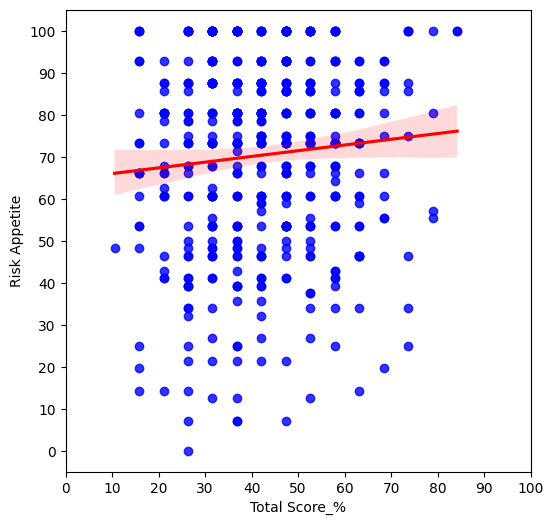

In [87]:
fig, axis = plt.subplots(1, 1, figsize = [6, 6])

sns.regplot( x = main["TotalScore_%"], y = (main["RiskAppetite1_%"] + main["RiskAppetite2_%"])/2, scatter_kws={"color": "blue"}, line_kws={"color": "red"})
axis.set(ylabel='Risk Appetite', xlabel='Total Score_%')

axis.set_xticks(np.arange(0, 110, step = 10))
axis.set_yticks(np.arange(0, 110, step = 10))
plt.show()

## Financial Habits vs risk literacy

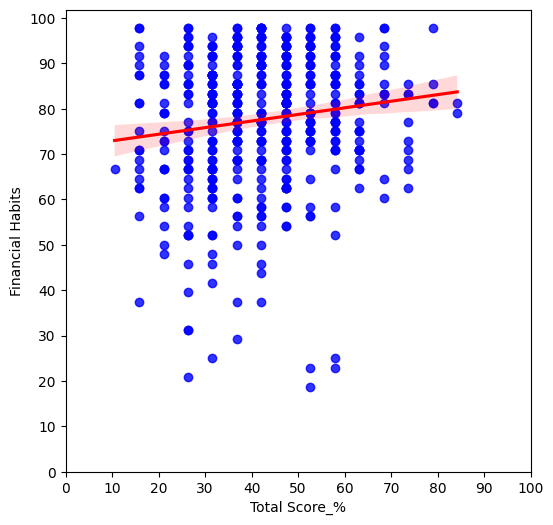

In [88]:
fig, axis = plt.subplots(1, 1, figsize = [6, 6])

sns.regplot( x = main["TotalScore_%"], y = main["FinancialHabits_%"], scatter_kws={"color": "blue"}, line_kws={"color": "red"})
axis.set(ylabel='Financial Habits', xlabel='Total Score_%')

axis.set_xticks(np.arange(0, 110, step = 10))
axis.set_yticks(np.arange(0, 110, step = 10))
plt.show()

## Risky Assets ownership vs risk literacy

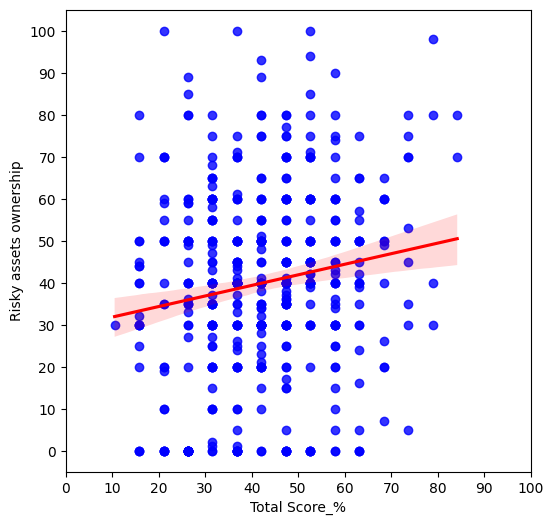

In [89]:
fig, axis = plt.subplots(1, 1, figsize = [6, 6])

sns.regplot( x = main["TotalScore_%"], y = main["RiskAssets_%"], scatter_kws={"color": "blue"}, line_kws={"color": "red"})
axis.set(ylabel='Risky assets ownership', xlabel='Total Score_%')

axis.set_xticks(np.arange(0, 110, step = 10))
axis.set_yticks(np.arange(0, 110, step = 10))
plt.show()

## Safe Assets ownership vs risk literacy

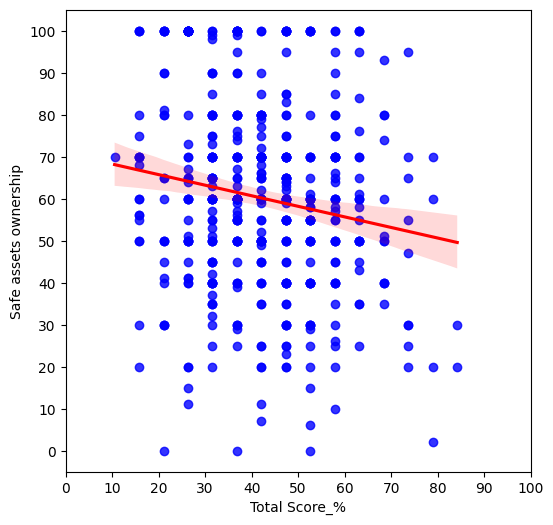

In [90]:
fig, axis = plt.subplots(1, 1, figsize = [6, 6])

sns.regplot( x = main["TotalScore_%"], y = main["SafeAssets_%"], scatter_kws={"color": "blue"}, line_kws={"color": "red"})
axis.set(ylabel='Safe assets ownership', xlabel='Total Score_%')

axis.set_xticks(np.arange(0, 110, step = 10))
axis.set_yticks(np.arange(0, 110, step = 10))
plt.show()

## Financial Literacy vs risk literacy

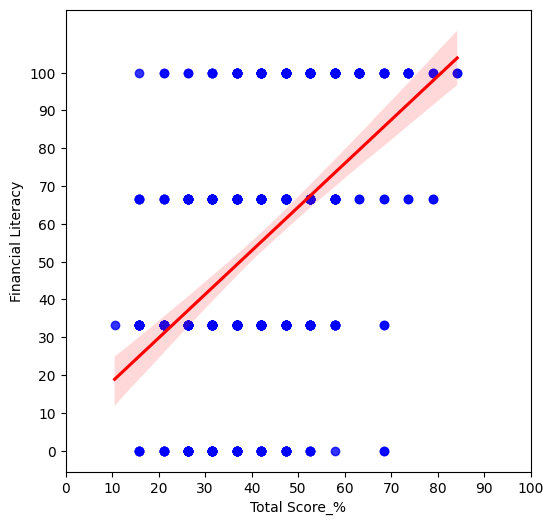

In [91]:
fig, axis = plt.subplots(1, 1, figsize = [6, 6])

sns.regplot( x = main["TotalScore_%"], y = main["FinancialLiteracy_%"], scatter_kws={"color": "blue"}, line_kws={"color": "red"})
axis.set(ylabel='Financial Literacy', xlabel='Total Score_%')

axis.set_xticks(np.arange(0, 110, step = 10))
axis.set_yticks(np.arange(0, 110, step = 10))
plt.show()

## CRT vs risk literacy

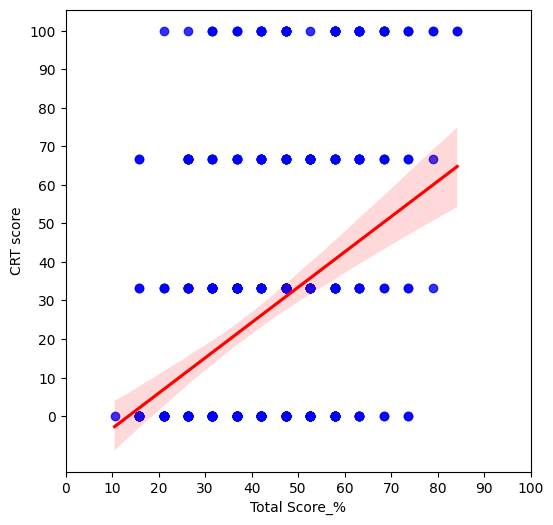

In [92]:
fig, axis = plt.subplots(1, 1, figsize = [6, 6])

sns.regplot( x = main["TotalScore_%"], y = main["CRTScore_%"], scatter_kws={"color": "blue"}, line_kws={"color": "red"})
axis.set(ylabel='CRT score', xlabel='Total Score_%')

axis.set_xticks(np.arange(0, 110, step = 10))
axis.set_yticks(np.arange(0, 110, step = 10))
plt.show()

In [93]:
# # income_terciles
# 1 - income = 1 --> 194 (194)
# 2 - income = 2 3 --> 335 (114 + 221)
# 3 - income = 4 5 6 --> 170 (76 + 52 + 42)

How to Form Terciles from Categorical Data
If your categorical data has a natural order (ordinal data), you can divide it into terciles—three groups each containing approximately one-third of the observations—by following these steps:
1. List the Categories in Order
Arrange your categories from lowest to highest based on their natural order.
2. Count Observations in Each Category
Determine the number of observations in each category.
3. Calculate Cumulative Percentages
For each category, calculate the cumulative percentage of observations up to and including that category.
4. Assign Tercile Groups
The first tercile includes categories up to the point where the cumulative percentage reaches or exceeds 33.3%.
The second tercile includes categories up to the point where the cumulative percentage reaches or exceeds 66.7%.
The third tercile includes the remaining categories.
5. A single Tercile muct never exceed 50% of the sample. If a Tercile exceeds 50% of the sample then it needs to be split up for the price of the Cumulative percentage being lower than 33.3% per Tercile.